# Cross Validation

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

Sample no.  Easting  Northing  MassArea  Thickness  [-5,-4)  [-4,-3)  \
0   VF95-06a     3133      9522    417.20         40      0.0     11.0   
1   VF95-08a     1907      8096    312.90         30      1.0     13.0   
2   VF97-20Q     5500      8723    208.60         20      2.0      7.0   
3  VF98-01a3     2665      9054    239.89         23      4.0     13.0   
4   VF98-02a     1154      7735    156.45         15      1.0     12.0   

   [-3,-2)  [-2,-1)  [-1,0)  [0,1)  [1,2)  [2,3)  [3,4)        radius  
0     21.0     22.0    23.0   17.0    4.0    0.0    0.0  10024.179418  
1     19.0     24.0    25.0   16.0    3.0    0.0    0.0   8317.563646  
2     14.0     21.0    26.0   21.0    6.0    1.0    1.0  10312.164128  
3     18.0     21.0    23.0   15.0    3.0    0.0    0.0   9438.068711  
4     19.0     23.0    24.0   17.0    3.0    0.0    0.0   7820.610015

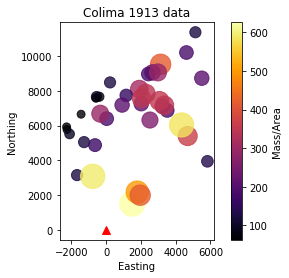

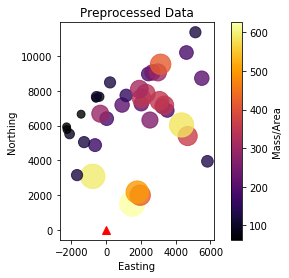

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

Easting  Northing  Elevation  MassArea   [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506          0   732.730  23.15290  25.4668  22.2407   
18     1957      1997          0   691.154  21.35410  24.7682  22.4602   
17     1787      2173          0   709.841  21.21370  24.7100  22.4801   
37     -770      3082          0   301.066  13.80220  19.2173  22.1297   
31    -1673      3152          0   149.680   9.51561  14.8613  20.3208   

    [-2,-1)    [-1,0)     [0,1)     [1,2)     [2,3)     [3,4)       radius  \
16  15.7304   8.99492   3.44384  0.823464  0.136596  0.010359  2124.861643   
18  16.5434   9.82586   3.90198  0.968656  0.164832  0.012894  2796.043276   
17  16.6062   9.88889   3.93999  0.980849  0.167220  0.013114  2813.413940   
37  20.4626  14.72470   7.12663  2.105690  0.398324  0.032906  3176.731654   
31  22.2637  18.49420  10.31720  3.459940  0.706562  0.060698  3568.477687   

      Residual  
16  117.086929  
18  165.664909  
17  141.786713  
37   50.641032  
31  119.590924

In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506       2500  1394.460  17.2005  24.2121  24.7779   
18     1957      1997       2500  1216.150  14.0160  22.3619  24.8640   
17     1787      2173       2500  1251.000  13.8770  22.2837  24.8861   
37     -770      3082       2500   359.399  14.8025  22.8299  24.5313   
31    -1673      3152       2500   134.301  15.3664  23.3283  24.4813   

    [-2,-1)   [-1,0)    [0,1)     [1,2)     [2,3)     [3,4)       radius  \
16  18.9162  10.8457  3.58293  0.449327  0.015328  0.000028  2124.861643   
18  20.2838  12.7356  4.93885  0.769130  0.030705  0.000063  2796.043276   
17  20.3522  12.8046  4.98427  0.780754  0.031310  0.000064  2813.413940   
37  19.4545  12.2828  5.13528  0.922533  0.041096  0.000091  3176.731654   
31  18.8191  11.7036  5.16746  1.079070  0.054478  0.000132  3568.477687   

      Residual  
16  222.828380  
18  291.502876  
17  249.880153  
37   60.452978  
31  107.303452

In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

centroid  density interval  lower  probability  upper
0      -4.5   1024.0  [-5,-4)   -5.0     0.068338   -4.0
1      -3.5   1024.0  [-4,-3)   -4.0     0.109203   -3.0
2      -2.5   1024.0  [-3,-2)   -3.0     0.146694   -2.0
3      -1.5   1024.0  [-2,-1)   -2.0     0.165650   -1.0
4      -0.5   1024.0   [-1,0)   -1.0     0.157243    0.0
5       0.5   1233.5    [0,1)    0.0     0.125474    1.0
6       1.5   1443.0    [1,2)    1.0     0.084166    2.0
7       2.5   1652.5    [2,3)    2.0     0.047459    3.0
8       3.5   1862.0    [3,4)    3.0     0.022496    4.0

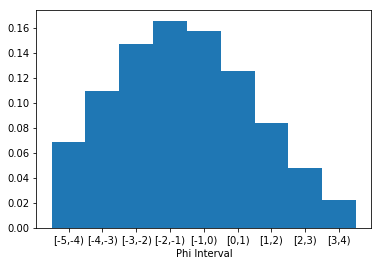

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.06250 seconds


Northing  Easting    [-5,-4)    [-4,-3)    [-3,-2)    [-2,-1)     [-1,0)  \
0      1506     1499  17.023654  24.058691  24.746126  19.010648  10.986457   
1      1997     1957  13.849036  22.187896  24.802962  20.364657  12.884741   
2      2173     1787  13.800371  22.209864  24.864958  20.379976  12.855621   
3      3082     -770  15.561092  23.674710  24.901902  19.059630  11.448421   
4      3152    -1673  16.255639  24.321103  24.942842  18.429623  10.768184   

      [0,1)     [1,2)     [2,3)     [3,4)     MassArea       radius  \
0  3.680616  0.476505  0.017266  0.000036  1316.804462  2124.861643   
1  5.062941  0.813217  0.034469  0.000080  1148.987823  2796.043276   
2  5.043105  0.811521  0.034502  0.000081  1166.987337  2813.413940   
3  4.522511  0.794749  0.036892  0.000093   300.904559  3176.731654   
4  4.367639  0.869463  0.045380  0.000126   111.014810  3568.477687   

     Residual  
0  210.419377  
1  275.404560  
2  233.099101  
3   50.613877  
4   88.698314

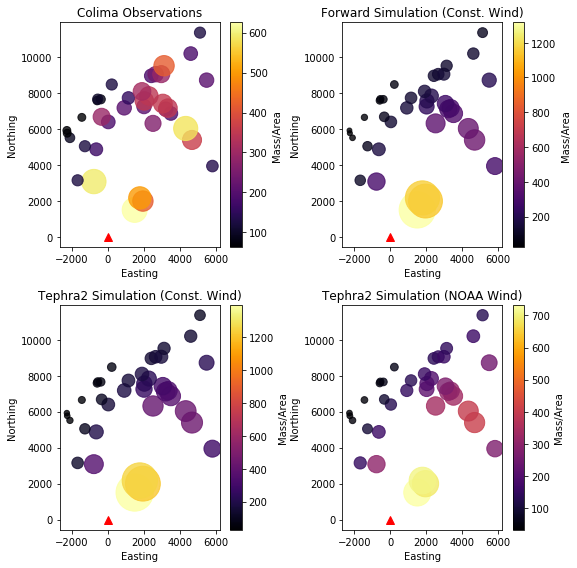

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


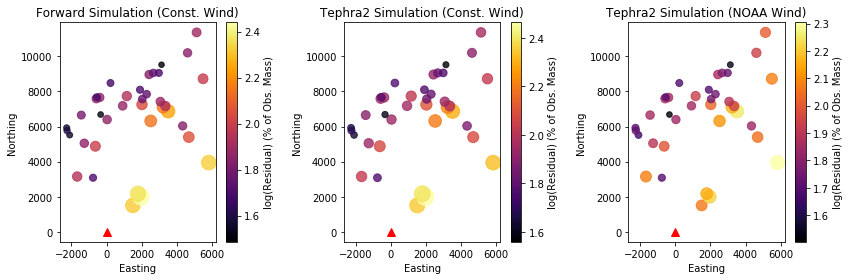

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

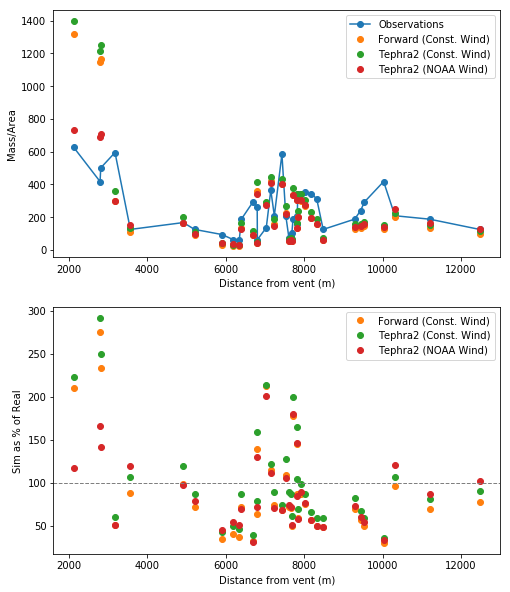

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

In [11]:
print(sum(obs_df["MassArea"].values))
print(sum(t2_df["MassArea"].values))
print(sum(forward_df["MassArea"].values))

9376.57
8279.3525
9591.480961126334


In [12]:
df = t2_df

file_tag = "forward"

err_type = "SSE"

## Leave out one

========LEFT OUT: (1499.0, 1506.0)========
a* = -2.18828	b* = -1.99302            	h1* = 3.20419
a = 1.11211	b = 1.13628	h1 = 28806.63155
Success: True, Optimization terminated successfully.
Iterations: 157
SSE: 230.24525017092236


Height  Suspended Mass
0    4430.75    2.639584e+09
1    5776.50    2.830886e+09
2    7122.25    2.938327e+09
3    8468.00    3.008256e+09
4    9813.75    3.055818e+09
5   11159.50    3.087840e+09
6   12505.25    3.107887e+09
7   13851.00    3.117934e+09
8   15196.75    3.119039e+09
9   16542.50    3.111632e+09
10  17888.25    3.095632e+09
11  19234.00    3.070438e+09
12  20579.75    3.034804e+09
13  21925.50    2.986528e+09
14  23271.25    2.921765e+09
15  24617.00    2.833356e+09
16  25962.75    2.705960e+09
17  27308.50    2.495562e+09
18  28654.25    1.838754e+09
19  30000.00    0.000000e+00

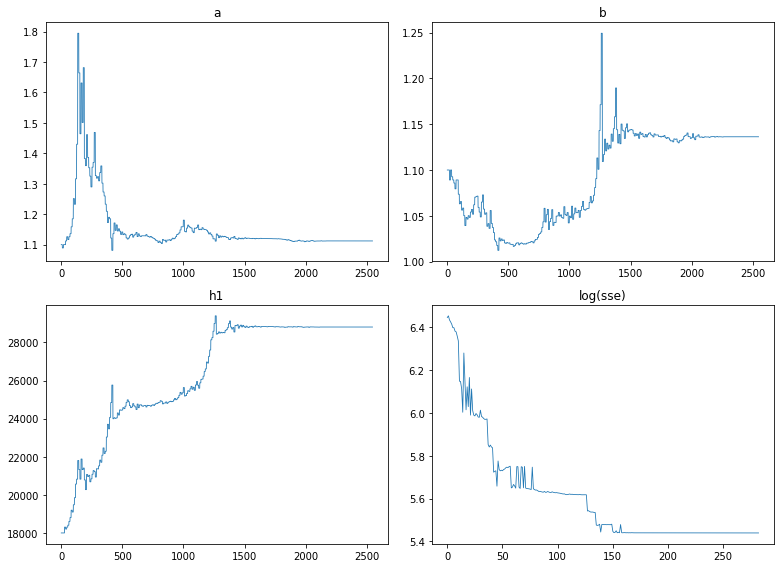

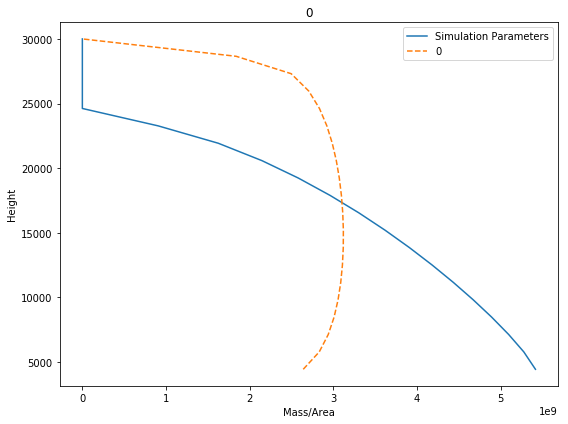

========LEFT OUT: (1957.0, 1997.0)========
a* = -2.05994	b* = -2.62270            	h1* = 2.17287
a = 1.12746	b = 1.07261	h1 = 26771.74260
Success: True, Optimization terminated successfully.
Iterations: 131
SSE: 252.5837215059004


Height  Suspended Mass
0    4430.75    2.686777e+09
1    5776.50    2.921746e+09
2    7122.25    3.061953e+09
3    8468.00    3.159995e+09
4    9813.75    3.233187e+09
5   11159.50    3.289396e+09
6   12505.25    3.332782e+09
7   13851.00    3.365693e+09
8   15196.75    3.389427e+09
9   16542.50    3.404563e+09
10  17888.25    3.411061e+09
11  19234.00    3.408209e+09
12  20579.75    3.394343e+09
13  21925.50    3.366130e+09
14  23271.25    3.316596e+09
15  24617.00    3.228230e+09
16  25962.75    3.029912e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

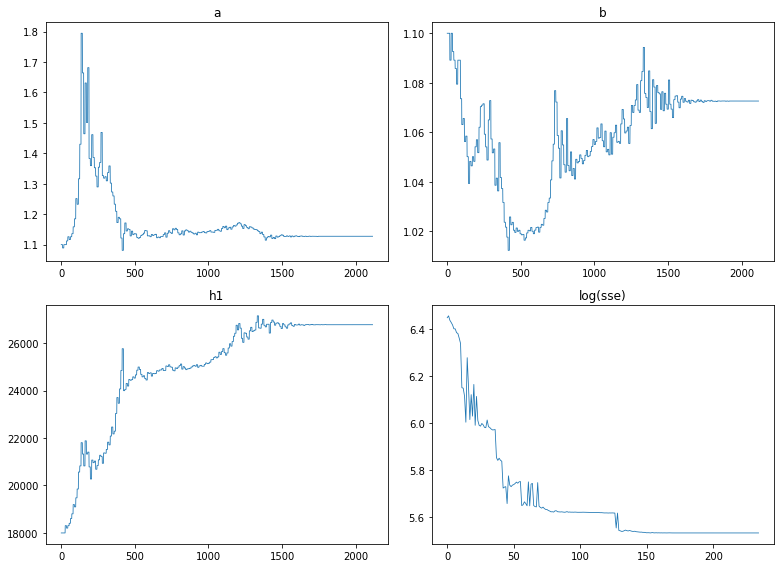

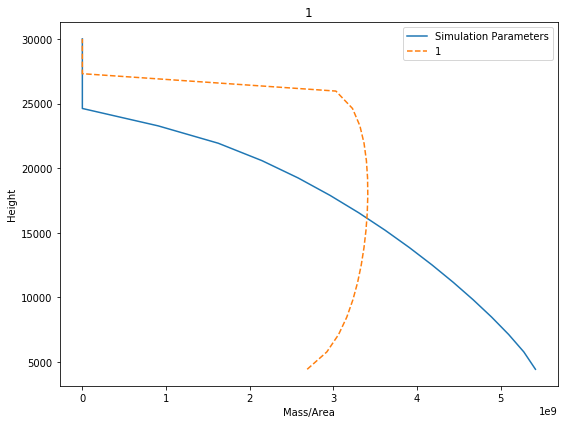

========LEFT OUT: (1787.0, 2173.0)========
a* = -2.12022	b* = -2.56924            	h1* = 2.17355
a = 1.12001	b = 1.07659	h1 = 26773.82950
Success: True, Optimization terminated successfully.
Iterations: 121
SSE: 254.56229538048456


Height  Suspended Mass
0    4430.75    2.737352e+09
1    5776.50    2.960667e+09
2    7122.25    3.092560e+09
3    8468.00    3.183844e+09
4    9813.75    3.251185e+09
5   11159.50    3.302127e+09
6   12505.25    3.340640e+09
7   13851.00    3.368944e+09
8   15196.75    3.388241e+09
9   16542.50    3.399030e+09
10  17888.25    3.401193e+09
11  19234.00    3.393931e+09
12  20579.75    3.375474e+09
13  21925.50    3.342325e+09
14  23271.25    3.287223e+09
15  24617.00    3.192010e+09
16  25962.75    2.983255e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

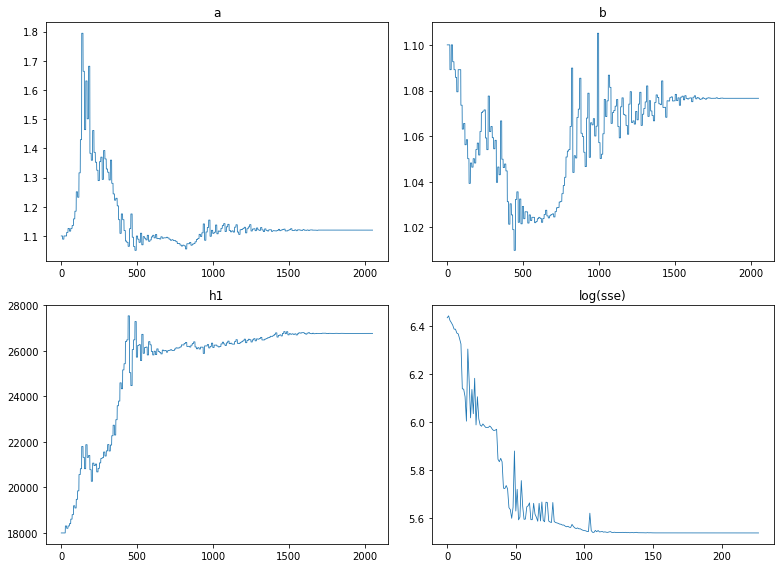

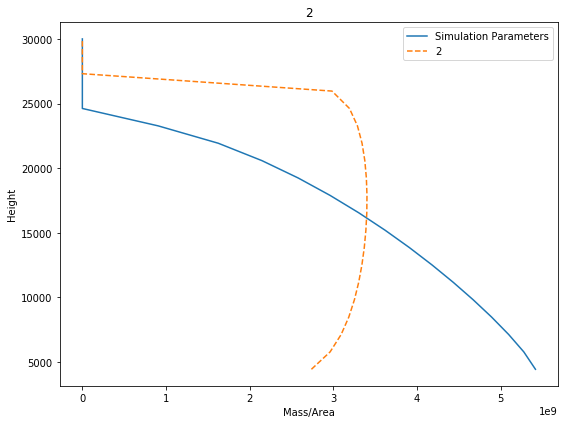

========LEFT OUT: (-770.0, 3082.0)========
a* = -2.18576	b* = -1.99632            	h1* = 3.20428
a = 1.11239	b = 1.13583	h1 = 28806.74045
Success: True, Optimization terminated successfully.
Iterations: 129
SSE: 229.88186294544016


Height  Suspended Mass
0    4430.75    2.636888e+09
1    5776.50    2.828621e+09
2    7122.25    2.936392e+09
3    8468.00    3.006606e+09
4    9813.75    3.054429e+09
5   11159.50    3.086697e+09
6   12505.25    3.106983e+09
7   13851.00    3.117266e+09
8   15196.75    3.118606e+09
9   16542.50    3.111438e+09
10  17888.25    3.095685e+09
11  19234.00    3.070748e+09
12  20579.75    3.035386e+09
13  21925.50    2.987404e+09
14  23271.25    2.922966e+09
15  24617.00    2.834929e+09
16  25962.75    2.707983e+09
17  27308.50    2.498198e+09
18  28654.25    1.842775e+09
19  30000.00    0.000000e+00

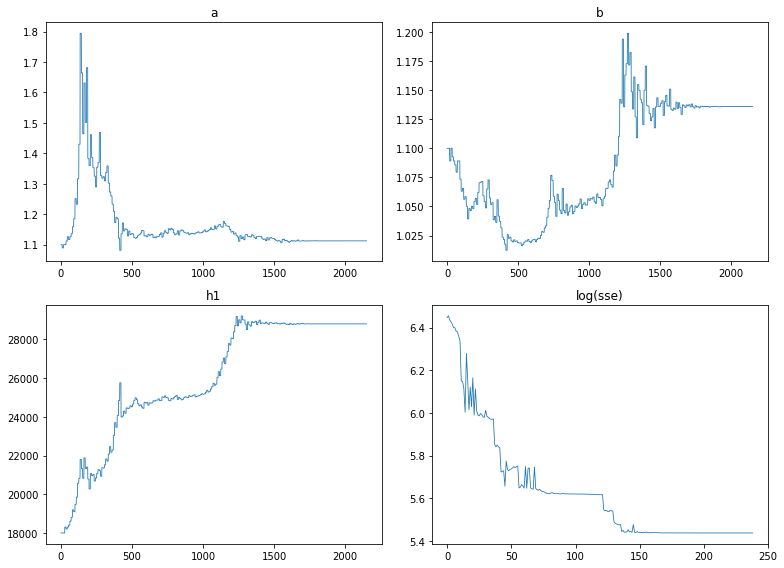

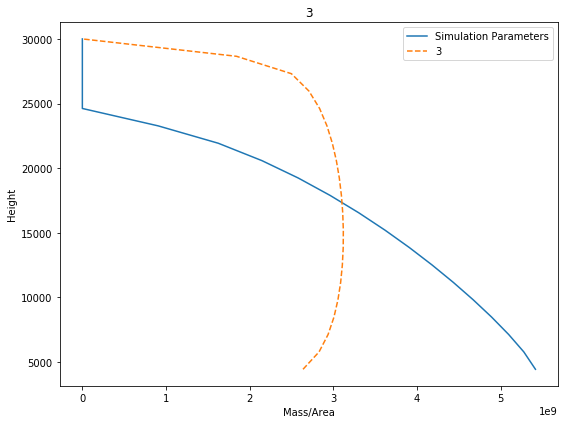

========LEFT OUT: (-1673.0, 3152.0)========
a* = -2.05928	b* = -2.62470            	h1* = 2.17301
a = 1.12755	b = 1.07246	h1 = 26772.15836
Success: True, Optimization terminated successfully.
Iterations: 126
SSE: 252.66338534610543


Height  Suspended Mass
0    4430.75    2.685948e+09
1    5776.50    2.921041e+09
2    7122.25    3.061348e+09
3    8468.00    3.159480e+09
4    9813.75    3.232756e+09
5   11159.50    3.289048e+09
6   12505.25    3.332517e+09
7   13851.00    3.365512e+09
8   15196.75    3.389333e+09
9   16542.50    3.404561e+09
10  17888.25    3.411157e+09
11  19234.00    3.408413e+09
12  20579.75    3.394668e+09
13  21925.50    3.366598e+09
14  23271.25    3.317240e+09
15  24617.00    3.229119e+09
16  25962.75    3.031262e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

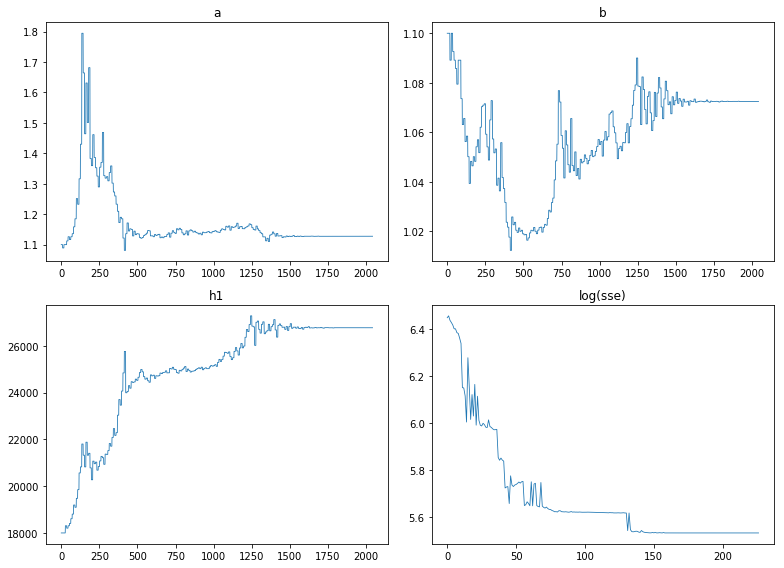

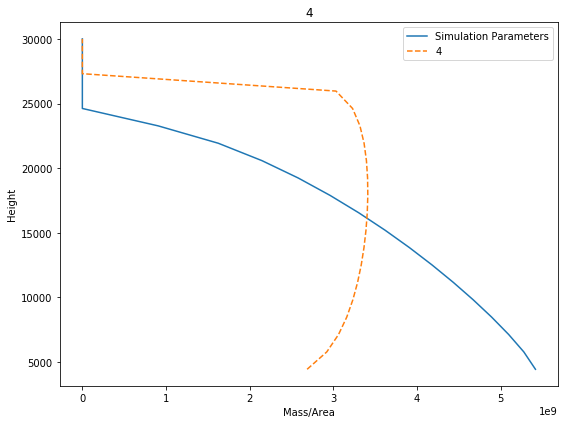

========LEFT OUT: (-637.0, 4876.0)========
a* = -2.19793	b* = -2.35396            	h1* = 2.54750
a = 1.11103	b = 1.09499	h1 = 27741.24035
Success: True, Optimization terminated successfully.
Iterations: 122
SSE: 238.0874887542468


Height  Suspended Mass
0    4430.75    2.677545e+09
1    5776.50    2.875463e+09
2    7122.25    2.989863e+09
3    8468.00    3.067179e+09
4    9813.75    3.122577e+09
5   11159.50    3.162902e+09
6   12505.25    3.191737e+09
7   13851.00    3.211080e+09
8   15196.75    3.222009e+09
9   16542.50    3.224971e+09
10  17888.25    3.219883e+09
11  19234.00    3.206101e+09
12  20579.75    3.182240e+09
13  21925.50    3.145715e+09
14  23271.25    3.091640e+09
15  24617.00    3.009704e+09
16  25962.75    2.872125e+09
17  27308.50    2.527267e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

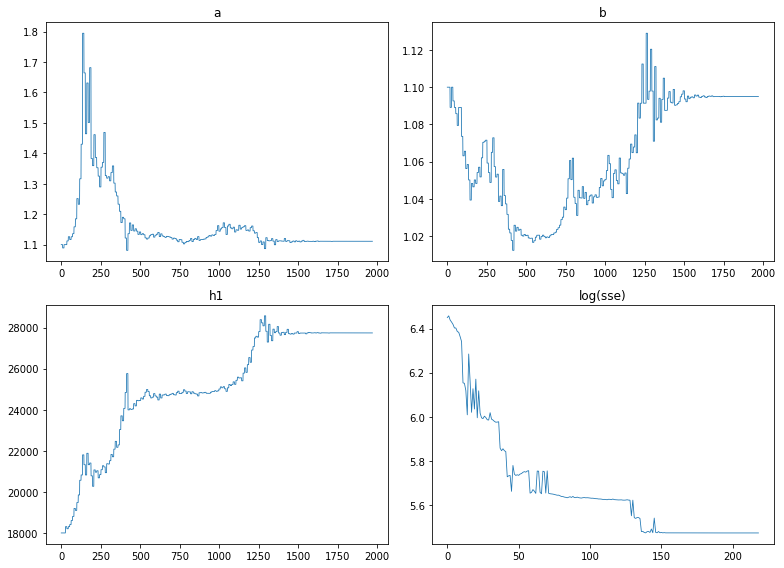

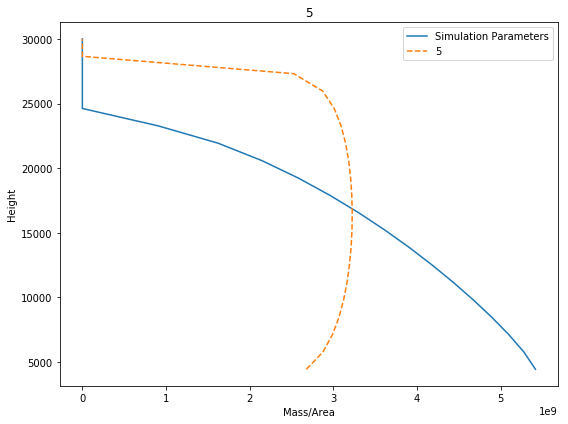

========LEFT OUT: (-1268.0, 5048.0)========
a* = -2.18918	b* = -2.36556            	h1* = 2.54657
a = 1.11201	b = 1.09390	h1 = 27739.21682
Success: True, Optimization terminated successfully.
Iterations: 132
SSE: 236.91233888285552


Height  Suspended Mass
0    4430.75    2.669500e+09
1    5776.50    2.868948e+09
2    7122.25    2.984474e+09
3    8468.00    3.062735e+09
4    9813.75    3.118977e+09
5   11159.50    3.160084e+09
6   12505.25    3.189666e+09
7   13851.00    3.209736e+09
8   15196.75    3.221384e+09
9   16542.50    3.225072e+09
10  17888.25    3.220727e+09
11  19234.00    3.207721e+09
12  20579.75    3.184683e+09
13  21925.50    3.149056e+09
14  23271.25    3.095993e+09
15  24617.00    3.015259e+09
16  25962.75    2.879239e+09
17  27308.50    2.536747e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

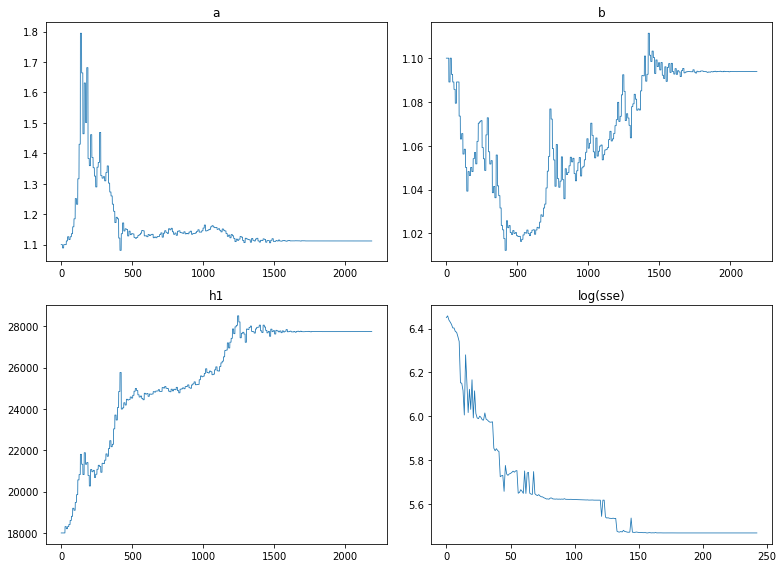

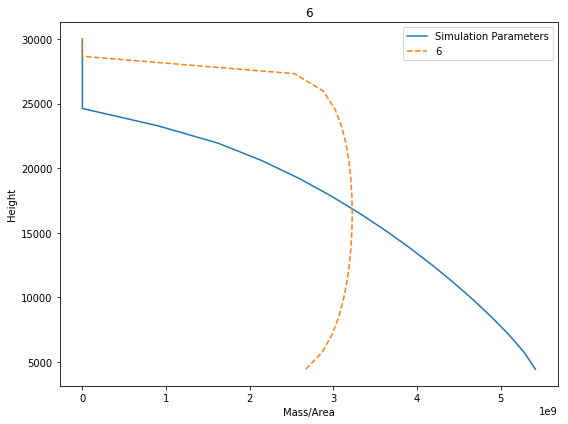

========LEFT OUT: (-2101.0, 5517.0)========
a* = -2.05764	b* = -2.62635            	h1* = 2.17282
a = 1.12776	b = 1.07234	h1 = 26771.57989
Success: True, Optimization terminated successfully.
Iterations: 117
SSE: 252.59330610163468


Height  Suspended Mass
0    4430.75    2.684534e+09
1    5776.50    2.919948e+09
2    7122.25    3.060487e+09
3    8468.00    3.158808e+09
4    9813.75    3.232248e+09
5   11159.50    3.288689e+09
6   12505.25    3.332295e+09
7   13851.00    3.365421e+09
8   15196.75    3.389369e+09
9   16542.50    3.404720e+09
10  17888.25    3.411441e+09
11  19234.00    3.408822e+09
12  20579.75    3.395209e+09
13  21925.50    3.367278e+09
14  23271.25    3.318076e+09
15  24617.00    3.230140e+09
16  25962.75    3.032516e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

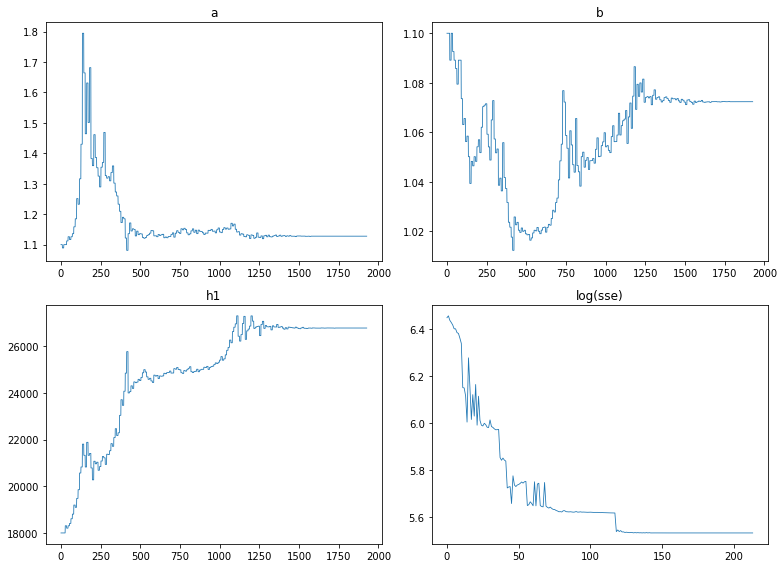

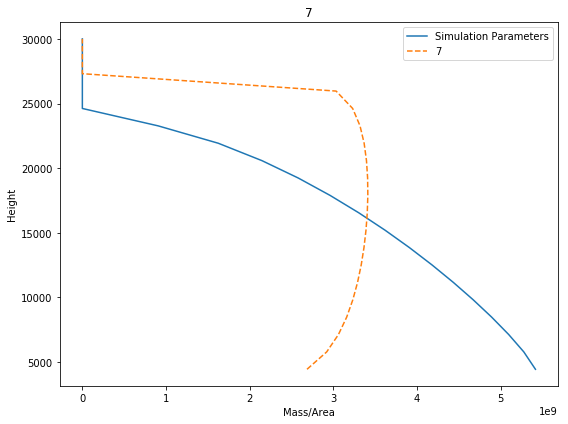

========LEFT OUT: (-2250.0, 5771.0)========
a* = -2.18496	b* = -1.99794            	h1* = 3.20431
a = 1.11248	b = 1.13561	h1 = 28806.77575
Success: True, Optimization terminated successfully.
Iterations: 193
SSE: 229.78530306861234


Height  Suspended Mass
0    4430.75    2.635830e+09
1    5776.50    2.827698e+09
2    7122.25    2.935581e+09
3    8468.00    3.005896e+09
4    9813.75    3.053815e+09
5   11159.50    3.086177e+09
6   12505.25    3.106557e+09
7   13851.00    3.116935e+09
8   15196.75    3.118374e+09
9   16542.50    3.111308e+09
10  17888.25    3.095661e+09
11  19234.00    3.070838e+09
12  20579.75    3.035598e+09
13  21925.50    2.987751e+09
14  23271.25    2.923465e+09
15  24617.00    2.835604e+09
16  25962.75    2.708876e+09
17  27308.50    2.499392e+09
18  28654.25    1.844645e+09
19  30000.00    0.000000e+00

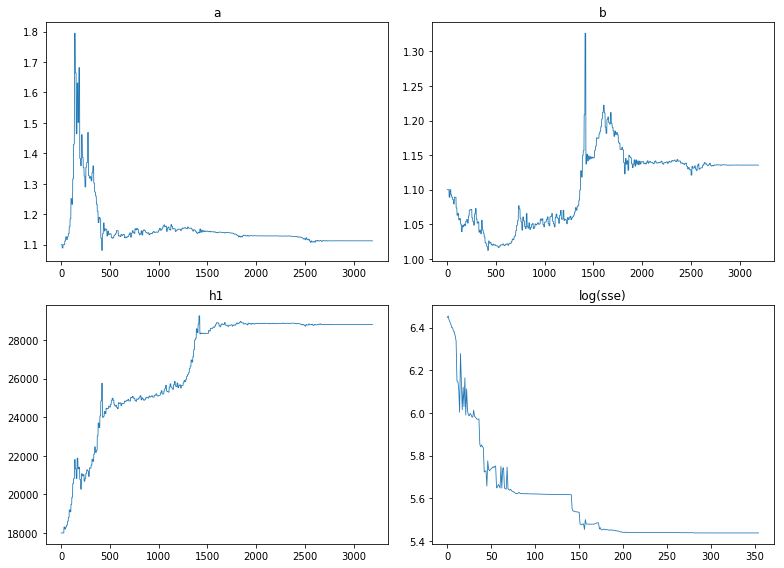

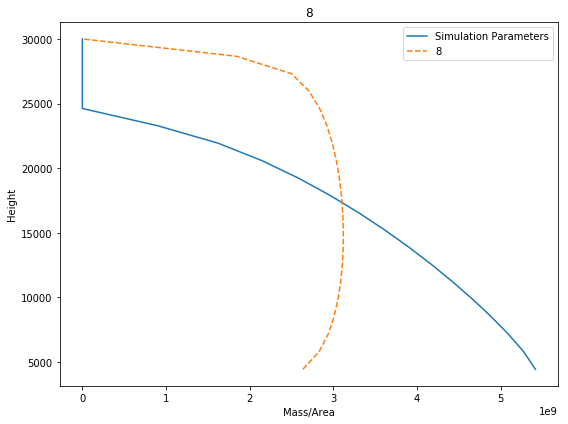

========LEFT OUT: (-2272.0, 5925.0)========
a* = -2.22282	b* = -2.32487            	h1* = 2.54668
a = 1.10830	b = 1.09780	h1 = 27739.46953
Success: True, Optimization terminated successfully.
Iterations: 103
SSE: 241.39028998730345


Height  Suspended Mass
0    4430.75    2.699826e+09
1    5776.50    2.893427e+09
2    7122.25    3.004679e+09
3    8468.00    3.079374e+09
4    9813.75    3.132446e+09
5   11159.50    3.170623e+09
6   12505.25    3.197421e+09
7   13851.00    3.214789e+09
8   15196.75    3.223768e+09
9   16542.50    3.224771e+09
10  17888.25    3.217684e+09
11  19234.00    3.201824e+09
12  20579.75    3.175754e+09
13  21925.50    3.136820e+09
14  23271.25    3.080015e+09
15  24617.00    2.994800e+09
16  25962.75    2.852798e+09
17  27308.50    2.499183e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

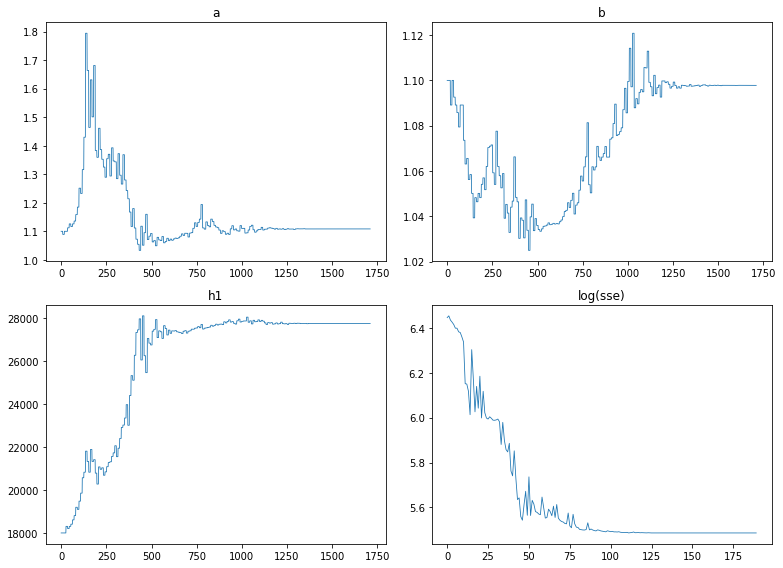

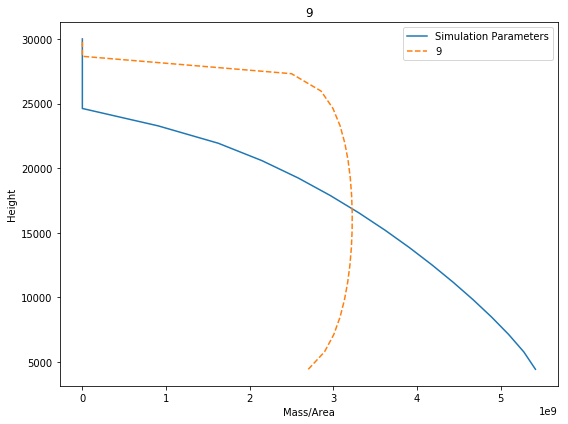

========LEFT OUT: (32.0, 6398.0)========
a* = -2.28824	b* = -2.25463            	h1* = 2.54761
a = 1.10144	b = 1.10491	h1 = 27741.48122
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 258.40606347836274


Height  Suspended Mass
0    4430.75    2.756259e+09
1    5776.50    2.938654e+09
2    7122.25    3.041804e+09
3    8468.00    3.109785e+09
4    9813.75    3.156919e+09
5   11159.50    3.189632e+09
6   12505.25    3.211260e+09
7   13851.00    3.223629e+09
8   15196.75    3.227685e+09
9   16542.50    3.223759e+09
10  17888.25    3.211652e+09
11  19234.00    3.190589e+09
12  20579.75    3.159015e+09
13  21925.50    3.114103e+09
14  23271.25    3.050576e+09
15  24617.00    2.957371e+09
16  25962.75    2.804839e+09
17  27308.50    2.432469e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

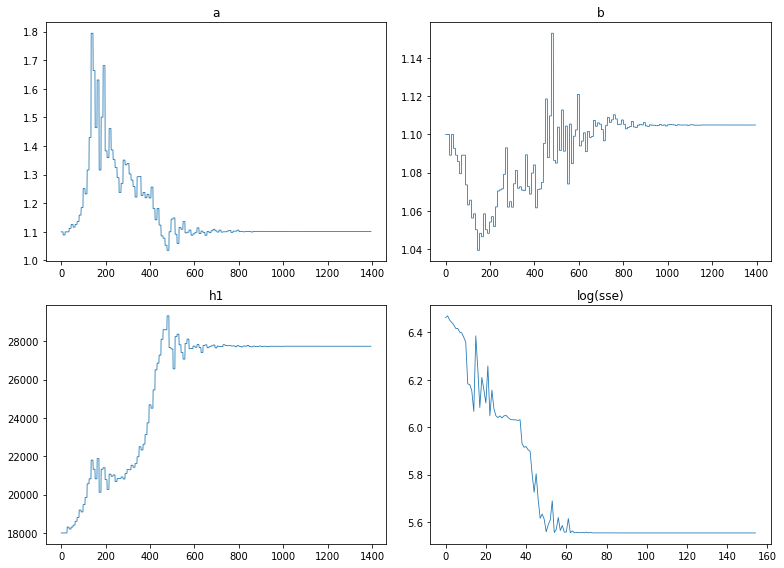

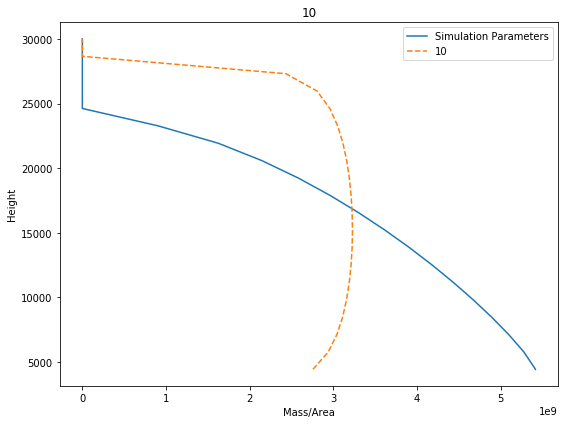

========LEFT OUT: (-337.0, 6683.0)========
a* = -2.19733	b* = -2.33870            	h1* = 2.54743
a = 1.11110	b = 1.09645	h1 = 27741.09817
Success: True, Optimization terminated successfully.
Iterations: 152
SSE: 236.95859054342742


Height  Suspended Mass
0    4430.75    2.680972e+09
1    5776.50    2.879025e+09
2    7122.25    2.993370e+09
3    8468.00    3.070532e+09
4    9813.75    3.125707e+09
5   11159.50    3.165748e+09
6   12505.25    3.194247e+09
7   13851.00    3.213199e+09
8   15196.75    3.223680e+09
9   16542.50    3.226130e+09
10  17888.25    3.220457e+09
11  19234.00    3.206004e+09
12  20579.75    3.181358e+09
13  21925.50    3.143901e+09
14  23271.25    3.088680e+09
15  24617.00    3.005259e+09
16  25962.75    2.865524e+09
17  27308.50    2.516206e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

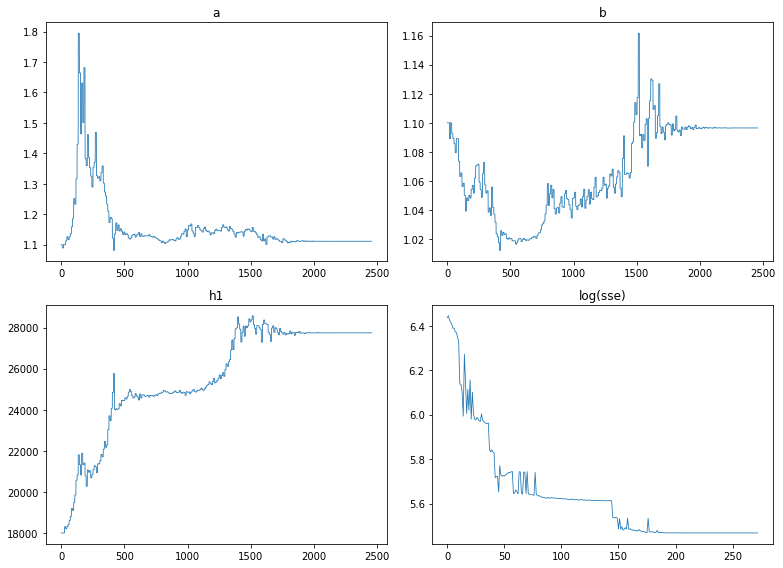

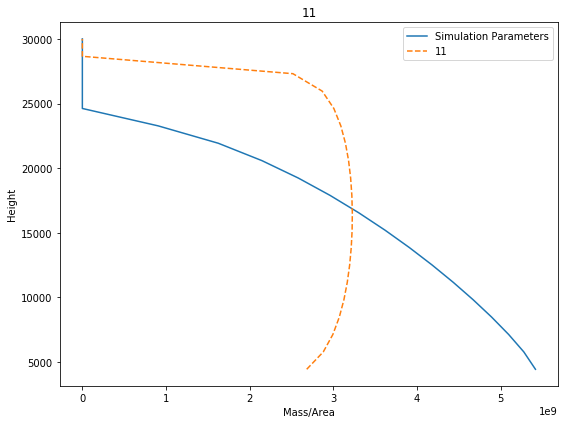

========LEFT OUT: (2519.0, 6318.0)========
a* = -2.18887	b* = -2.35739            	h1* = 2.54639
a = 1.11204	b = 1.09467	h1 = 27738.82704
Success: True, Optimization terminated successfully.
Iterations: 154
SSE: 237.00359289430511


Height  Suspended Mass
0    4430.75    2.671320e+09
1    5776.50    2.870841e+09
2    7122.25    2.986340e+09
3    8468.00    3.064520e+09
4    9813.75    3.120645e+09
5   11159.50    3.161603e+09
6   12505.25    3.191008e+09
7   13851.00    3.210871e+09
8   15196.75    3.222284e+09
9   16542.50    3.225701e+09
10  17888.25    3.221047e+09
11  19234.00    3.207684e+09
12  20579.75    3.184231e+09
13  21925.50    3.148109e+09
14  23271.25    3.094436e+09
15  24617.00    3.012907e+09
16  25962.75    2.875725e+09
17  27308.50    2.530729e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

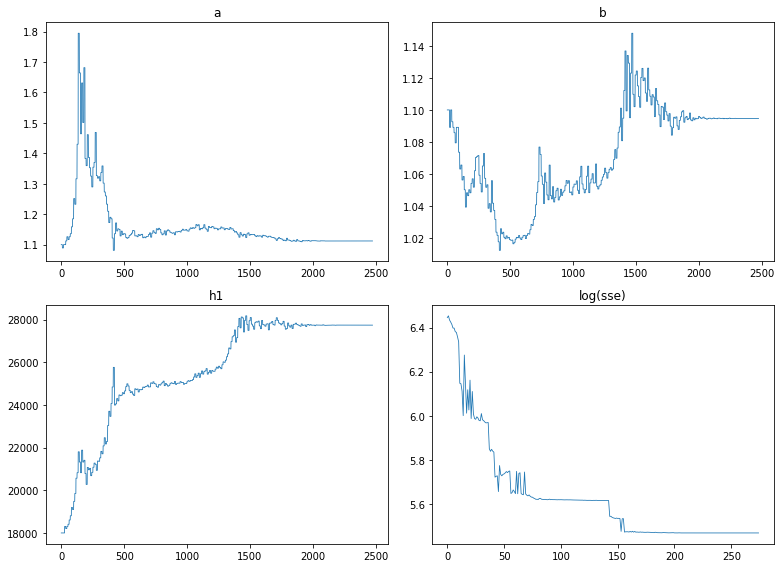

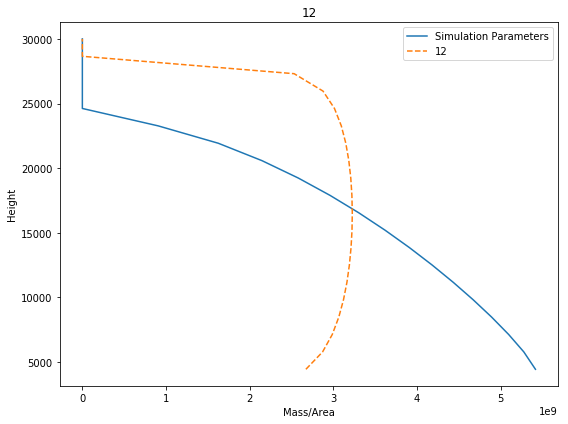

========LEFT OUT: (-1439.0, 6652.0)========
a* = -2.06616	b* = -2.61843            	h1* = 2.17377
a = 1.12667	b = 1.07292	h1 = 26774.47495
Success: True, Optimization terminated successfully.
Iterations: 130
SSE: 253.36473469993152


Height  Suspended Mass
0    4430.75    2.691749e+09
1    5776.50    2.925495e+09
2    7122.25    3.064839e+09
3    8468.00    3.162187e+09
4    9813.75    3.234784e+09
5   11159.50    3.290466e+09
6   12505.25    3.333371e+09
7   13851.00    3.365833e+09
8   15196.75    3.389144e+09
9   16542.50    3.403871e+09
10  17888.25    3.409972e+09
11  19234.00    3.406726e+09
12  20579.75    3.392464e+09
13  21925.50    3.363843e+09
14  23271.25    3.313879e+09
15  24617.00    3.225050e+09
16  25962.75    3.026326e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

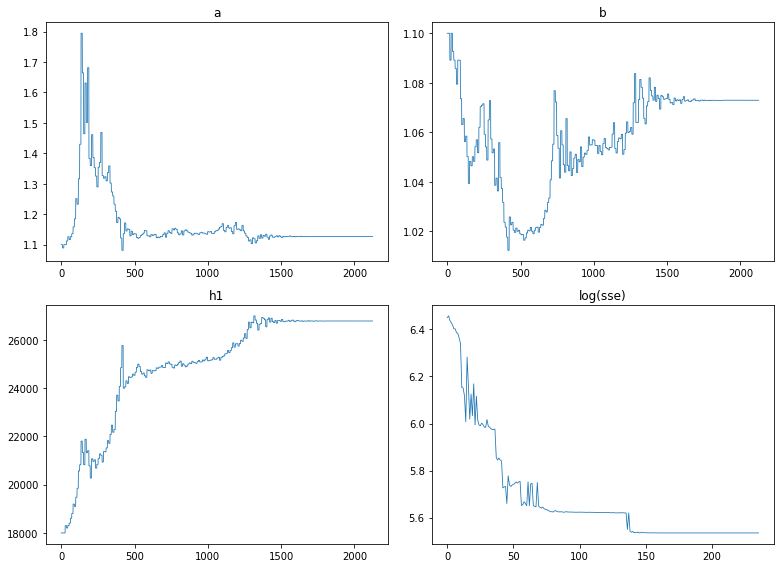

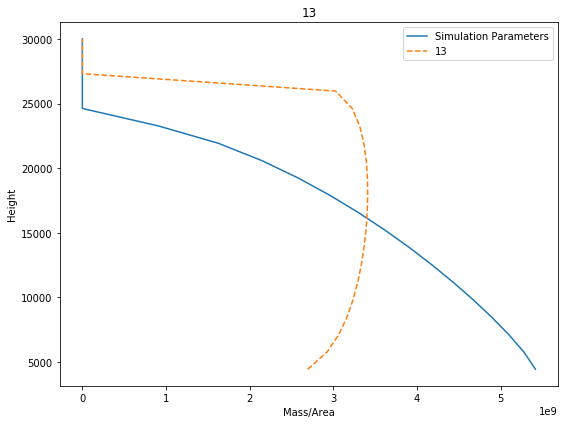

========LEFT OUT: (5823.0, 3944.0)========
a* = -2.19699	b* = -2.35525            	h1* = 2.54745
a = 1.11114	b = 1.09487	h1 = 27741.13688
Success: True, Optimization terminated successfully.
Iterations: 129
SSE: 237.92228537176518


Height  Suspended Mass
0    4430.75    2.676666e+09
1    5776.50    2.874748e+09
2    7122.25    2.989269e+09
3    8468.00    3.066687e+09
4    9813.75    3.122176e+09
5   11159.50    3.162585e+09
6   12505.25    3.191502e+09
7   13851.00    3.210925e+09
8   15196.75    3.221932e+09
9   16542.50    3.224973e+09
10  17888.25    3.219967e+09
11  19234.00    3.206272e+09
12  20579.75    3.182502e+09
13  21925.50    3.146077e+09
14  23271.25    3.092115e+09
15  24617.00    3.010316e+09
16  25962.75    2.872917e+09
17  27308.50    2.528371e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

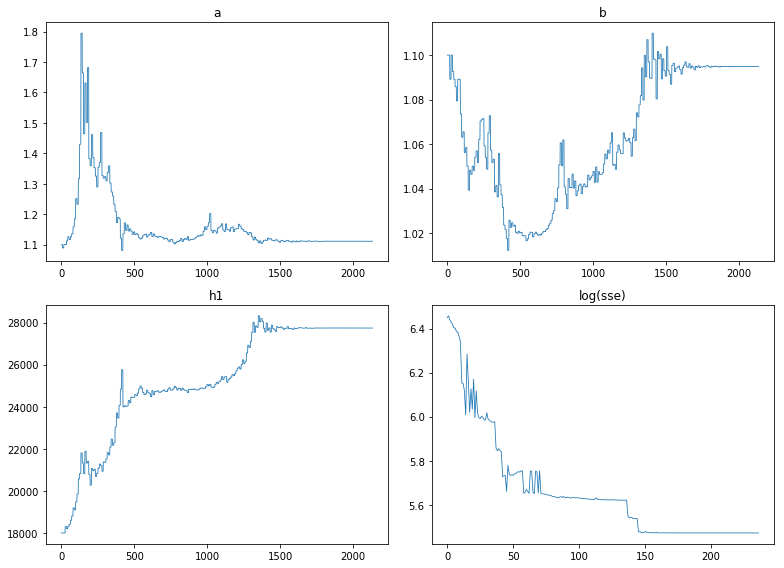

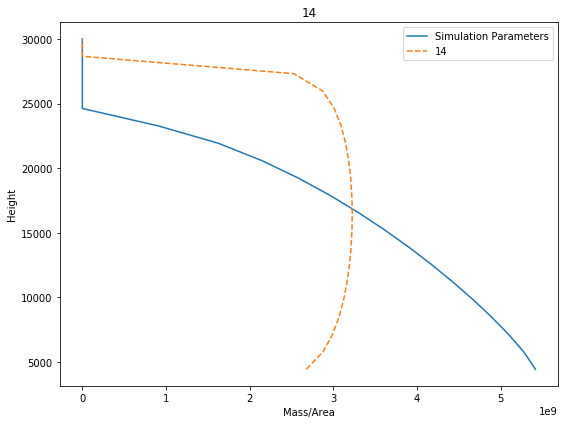

========LEFT OUT: (4688.0, 5396.0)========
a* = -2.19549	b* = -2.35313            	h1* = 2.54662
a = 1.11130	b = 1.09507	h1 = 27739.32577
Success: True, Optimization terminated successfully.
Iterations: 142
SSE: 237.3439847065629


Height  Suspended Mass
0    4430.75    2.676365e+09
1    5776.50    2.874721e+09
2    7122.25    2.989403e+09
3    8468.00    3.066928e+09
4    9813.75    3.122490e+09
5   11159.50    3.162948e+09
6   12505.25    3.191892e+09
7   13851.00    3.211326e+09
8   15196.75    3.222327e+09
9   16542.50    3.225347e+09
10  17888.25    3.220302e+09
11  19234.00    3.206548e+09
12  20579.75    3.182696e+09
13  21925.50    3.146159e+09
14  23271.25    3.092040e+09
15  24617.00    3.010009e+09
16  25962.75    2.872208e+09
17  27308.50    2.526291e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

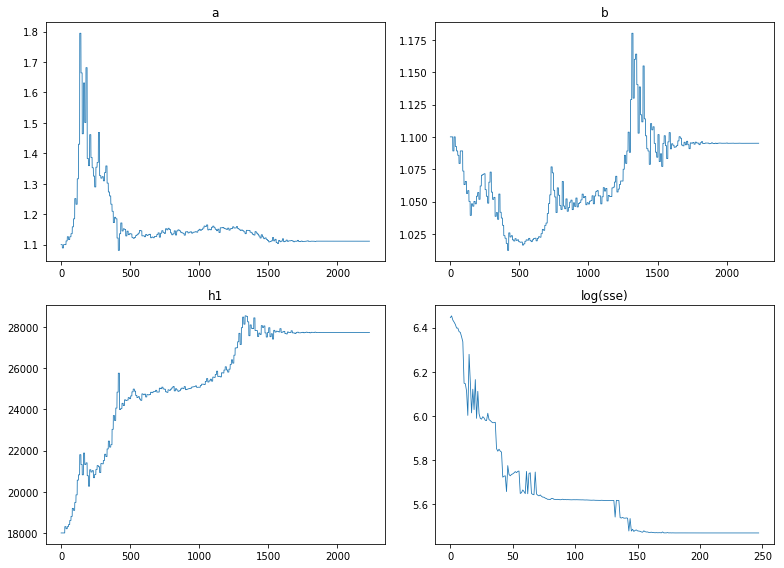

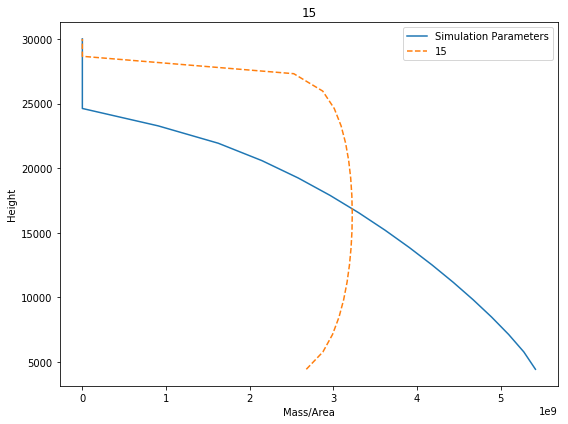

========LEFT OUT: (918.0, 7180.0)========
a* = -2.37075	b* = -2.16089            	h1* = 2.56497
a = 1.09341	b = 1.11522	h1 = 27778.87628
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 241.11117040132805


Height  Suspended Mass
0    4430.75    2.826669e+09
1    5776.50    2.995185e+09
2    7122.25    3.088262e+09
3    8468.00    3.147847e+09
4    9813.75    3.187508e+09
5   11159.50    3.213300e+09
6   12505.25    3.228341e+09
7   13851.00    3.234304e+09
8   15196.75    3.232021e+09
9   16542.50    3.221720e+09
10  17888.25    3.203101e+09
11  19234.00    3.175278e+09
12  20579.75    3.136558e+09
13  21925.50    3.083928e+09
14  23271.25    3.011827e+09
15  24617.00    2.908731e+09
16  25962.75    2.744210e+09
17  27308.50    2.361210e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

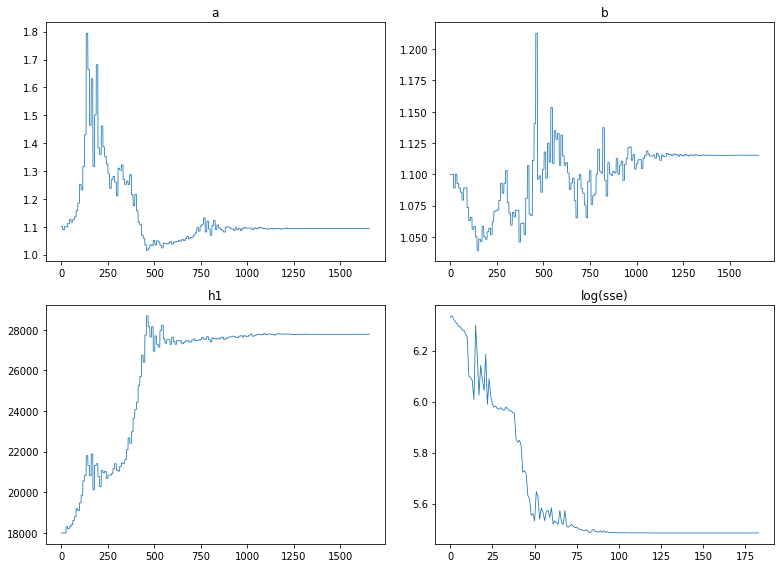

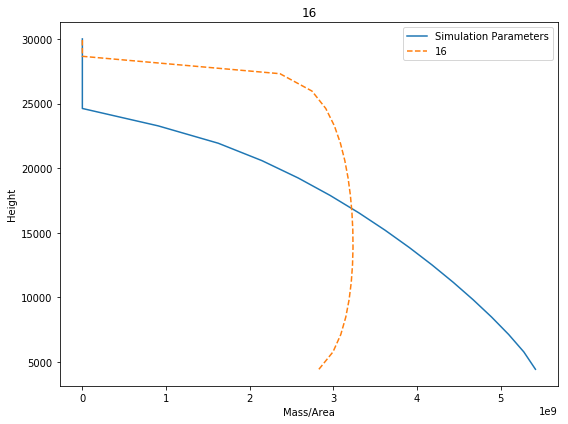

========LEFT OUT: (4337.0, 6035.0)========
a* = -2.28638	b* = -2.22974            	h1* = 2.55895
a = 1.10163	b = 1.10756	h1 = 27765.98074
Success: True, Optimization terminated successfully.
Iterations: 82
SSE: 242.5801072341713


Height  Suspended Mass
0    4430.75    2.760841e+09
1    5776.50    2.943482e+09
2    7122.25    3.046549e+09
3    8468.00    3.114277e+09
4    9813.75    3.161040e+09
5   11159.50    3.193284e+09
6   12505.25    3.214357e+09
7   13851.00    3.226084e+09
8   15196.75    3.229411e+09
9   16542.50    3.224661e+09
10  17888.25    3.211624e+09
11  19234.00    3.189509e+09
12  20579.75    3.156739e+09
13  21925.50    3.110455e+09
14  23271.25    3.045335e+09
15  24617.00    2.950276e+09
16  25962.75    2.795742e+09
17  27308.50    2.426334e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

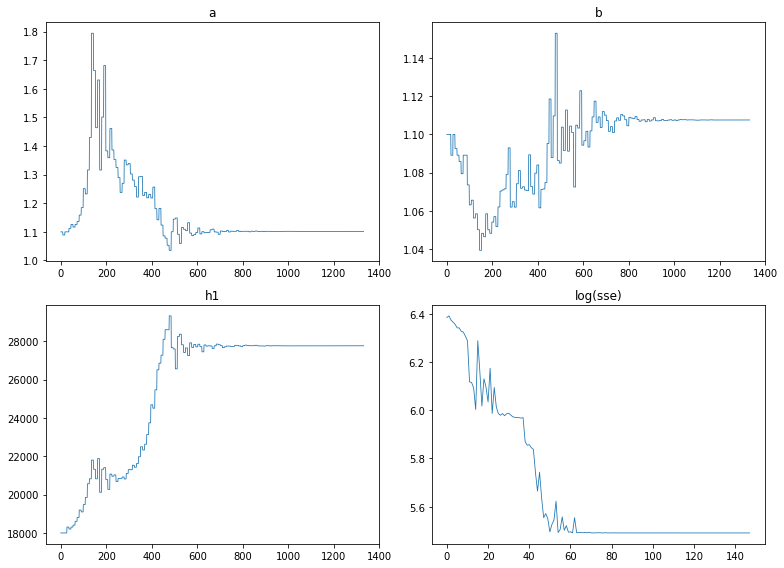

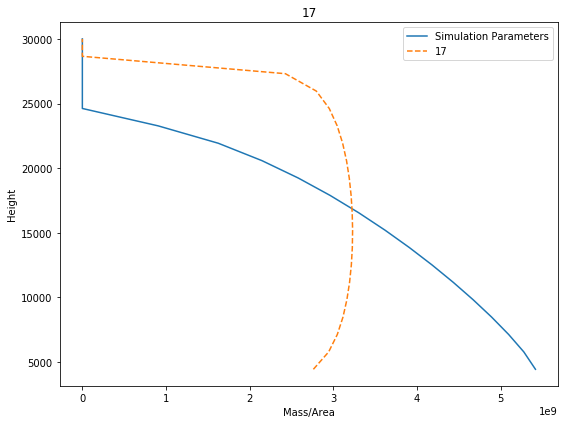

========LEFT OUT: (2019.0, 7255.0)========
a* = -2.29284	b* = -2.22692            	h1* = 2.55906
a = 1.10098	b = 1.10786	h1 = 27766.21065
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 241.9668511421896


Height  Suspended Mass
0    4430.75    2.765276e+09
1    5776.50    2.946822e+09
2    7122.25    3.049140e+09
3    8468.00    3.116276e+09
4    9813.75    3.162538e+09
5   11159.50    3.194342e+09
6   12505.25    3.215015e+09
7   13851.00    3.226374e+09
8   15196.75    3.229353e+09
9   16542.50    3.224271e+09
10  17888.25    3.210912e+09
11  19234.00    3.188481e+09
12  20579.75    3.155393e+09
13  21925.50    3.108786e+09
14  23271.25    3.043326e+09
15  24617.00    2.947894e+09
16  25962.75    2.792918e+09
17  27308.50    2.422883e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

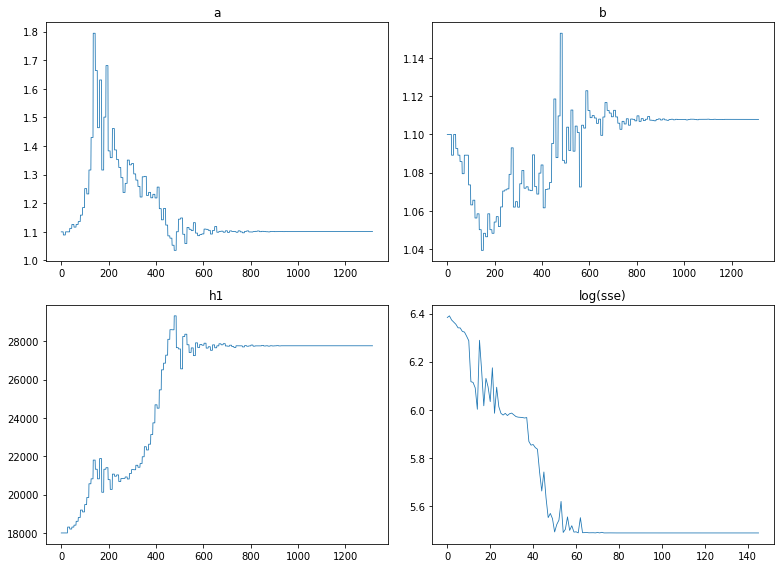

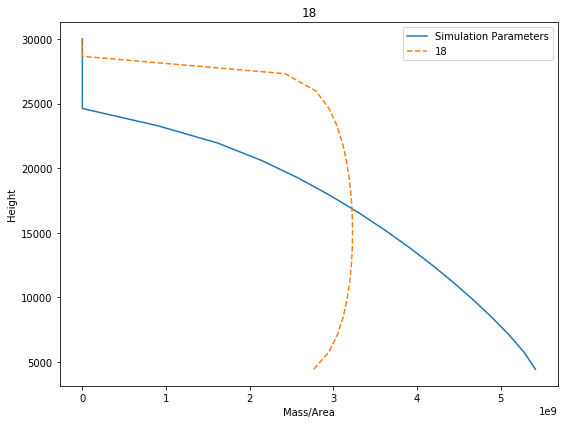

========LEFT OUT: (-586.0, 7588.0)========
a* = -2.05944	b* = -2.62128            	h1* = 2.17271
a = 1.12753	b = 1.07271	h1 = 26771.26590
Success: True, Optimization terminated successfully.
Iterations: 130
SSE: 252.4864806850403


Height  Suspended Mass
0    4430.75    2.686707e+09
1    5776.50    2.921780e+09
2    7122.25    3.062047e+09
3    8468.00    3.160126e+09
4    9813.75    3.233340e+09
5   11159.50    3.289562e+09
6   12505.25    3.332951e+09
7   13851.00    3.365857e+09
8   15196.75    3.389578e+09
9   16542.50    3.404693e+09
10  17888.25    3.411161e+09
11  19234.00    3.408267e+09
12  20579.75    3.394346e+09
13  21925.50    3.366058e+09
14  23271.25    3.316419e+09
15  24617.00    3.227891e+09
16  25962.75    3.029218e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

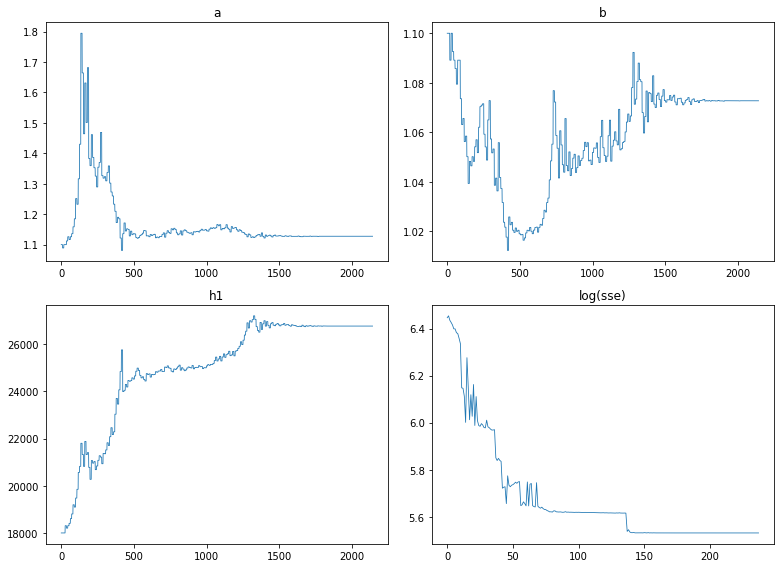

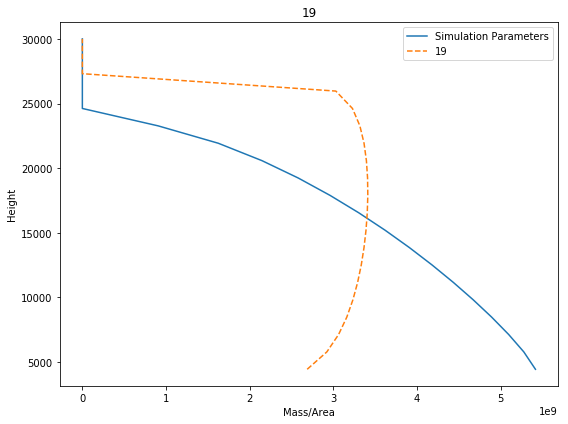

========LEFT OUT: (-387.0, 7656.0)========
a* = -2.22336	b* = -2.31867            	h1* = 2.54903
a = 1.10824	b = 1.09840	h1 = 27744.56821
Success: True, Optimization terminated successfully.
Iterations: 109
SSE: 239.08761244752782


Height  Suspended Mass
0    4430.75    2.701476e+09
1    5776.50    2.894976e+09
2    7122.25    3.006106e+09
3    8468.00    3.080663e+09
4    9813.75    3.133584e+09
5   11159.50    3.171598e+09
6   12505.25    3.198219e+09
7   13851.00    3.215395e+09
8   15196.75    3.224166e+09
9   16542.50    3.224943e+09
10  17888.25    3.217607e+09
11  19234.00    3.201470e+09
12  20579.75    3.175091e+09
13  21925.50    3.135805e+09
14  23271.25    3.078593e+09
15  24617.00    2.992899e+09
16  25962.75    2.850346e+09
17  27308.50    2.497062e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

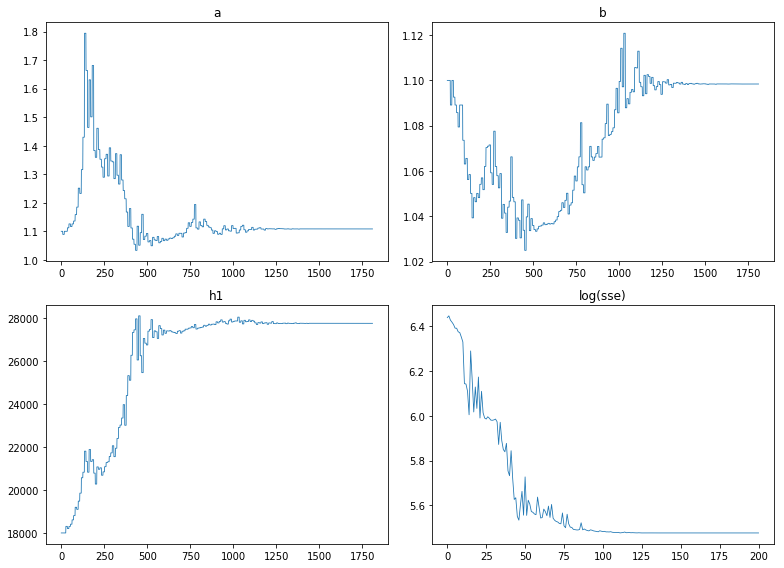

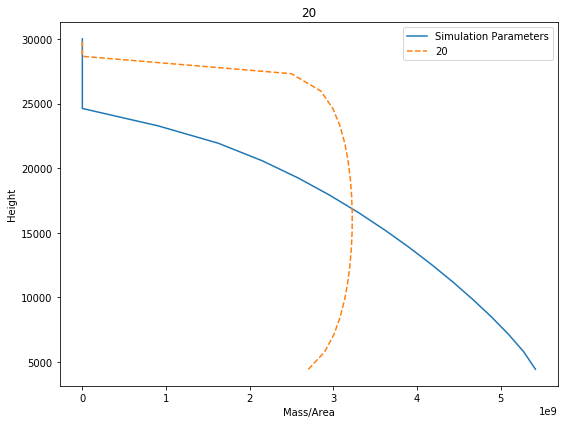

========LEFT OUT: (-555.0, 7666.0)========
a* = -2.24504	b* = -2.29159            	h1* = 2.55145
a = 1.10592	b = 1.10111	h1 = 27749.79929
Success: True, Optimization terminated successfully.
Iterations: 118
SSE: 235.04693145406077


Height  Suspended Mass
0    4430.75    2.721016e+09
1    5776.50    2.910765e+09
2    7122.25    3.019148e+09
3    8468.00    3.091405e+09
4    9813.75    3.142275e+09
5   11159.50    3.178386e+09
6   12505.25    3.203194e+09
7   13851.00    3.218607e+09
8   15196.75    3.225629e+09
9   16542.50    3.224645e+09
10  17888.25    3.215506e+09
11  19234.00    3.197493e+09
12  20579.75    3.169121e+09
13  21925.50    3.127665e+09
14  23271.25    3.068013e+09
15  24617.00    2.979436e+09
16  25962.75    2.833176e+09
17  27308.50    2.474519e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

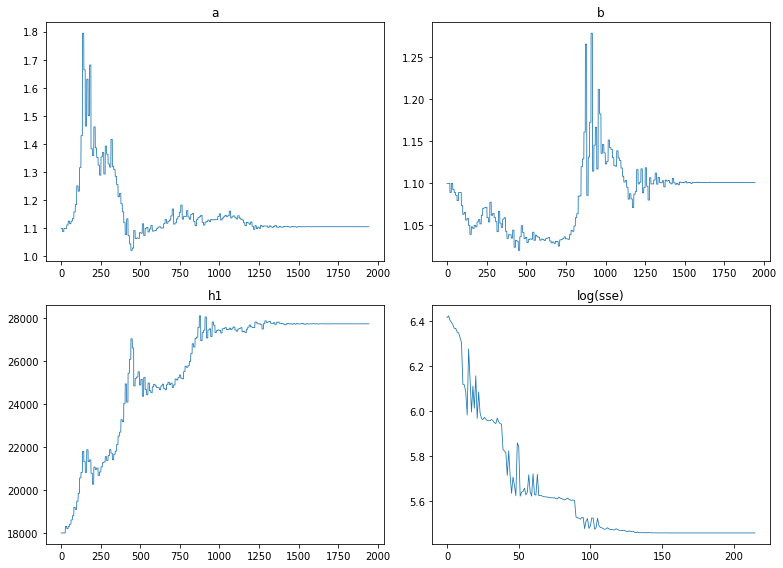

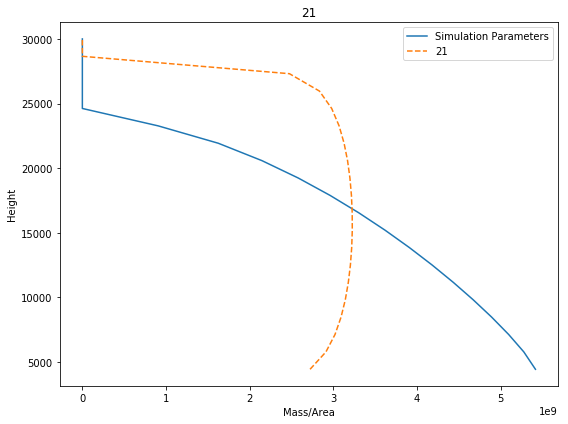

========LEFT OUT: (3512.0, 6869.0)========
a* = -2.23860	b* = -2.29709            	h1* = 2.55060
a = 1.10661	b = 1.10055	h1 = 27747.97257
Success: True, Optimization terminated successfully.
Iterations: 135
SSE: 234.99997054691488


Height  Suspended Mass
0    4430.75    2.715891e+09
1    5776.50    2.906755e+09
2    7122.25    3.015928e+09
3    8468.00    3.088830e+09
4    9813.75    3.140260e+09
5   11159.50    3.176879e+09
6   12505.25    3.202160e+09
7   13851.00    3.218022e+09
8   15196.75    3.225481e+09
9   16542.50    3.224927e+09
10  17888.25    3.216218e+09
11  19234.00    3.198642e+09
12  20579.75    3.170723e+09
13  21925.50    3.129747e+09
14  23271.25    3.070619e+09
15  24617.00    2.982636e+09
16  25962.75    2.837096e+09
17  27308.50    2.479184e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

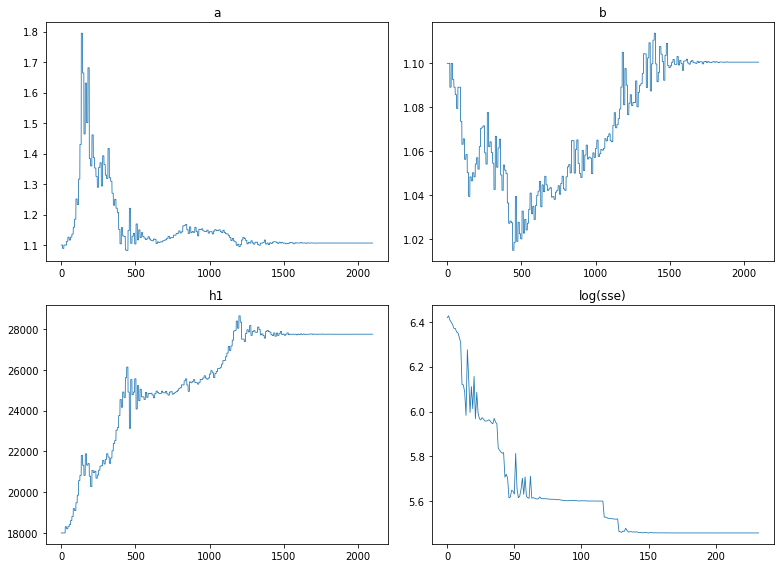

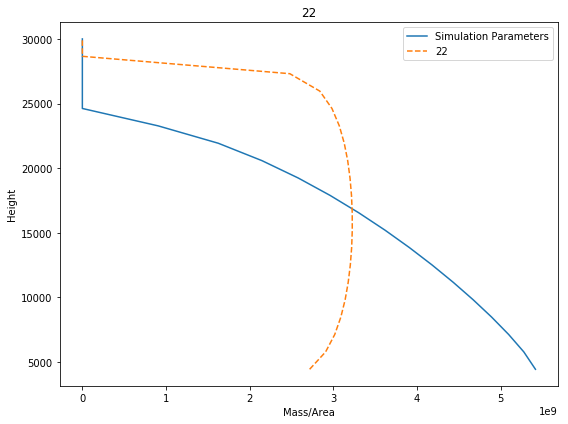

========LEFT OUT: (3226.0, 7110.0)========
a* = -2.19511	b* = -1.97385            	h1* = 3.20463
a = 1.11135	b = 1.13892	h1 = 28807.14988
Success: True, Optimization terminated successfully.
Iterations: 172
SSE: 229.64498071371523


Height  Suspended Mass
0    4430.75    2.650437e+09
1    5776.50    2.840598e+09
2    7122.25    2.947028e+09
3    8468.00    3.015993e+09
4    9813.75    3.062604e+09
5   11159.50    3.093667e+09
6   12505.25    3.112736e+09
7   13851.00    3.121773e+09
8   15196.75    3.121823e+09
9   16542.50    3.113306e+09
10  17888.25    3.096125e+09
11  19234.00    3.069661e+09
12  20579.75    3.032642e+09
13  21925.50    2.982831e+09
14  23271.25    2.916327e+09
15  24617.00    2.825878e+09
16  25962.75    2.695958e+09
17  27308.50    2.482086e+09
18  28654.25    1.818527e+09
19  30000.00    0.000000e+00

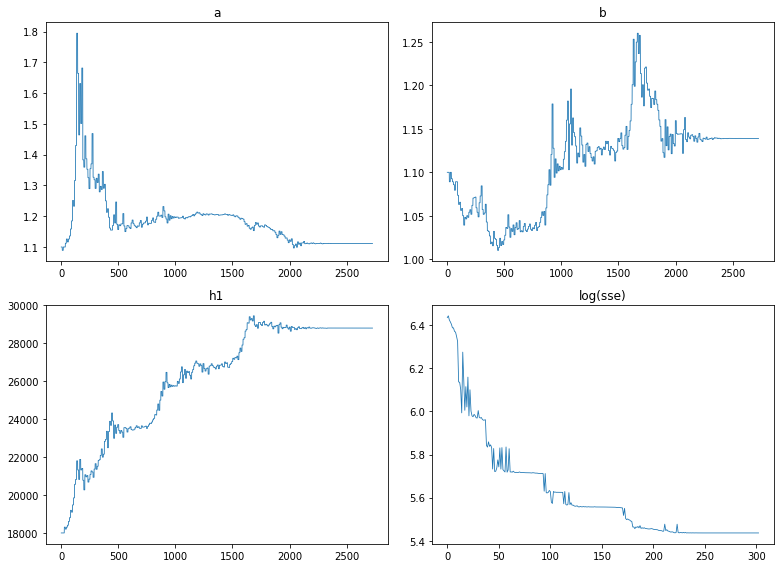

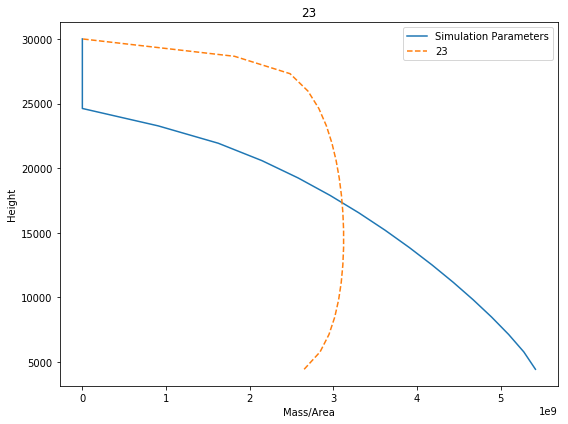

========LEFT OUT: (1154.0, 7735.0)========
a* = -2.21358	b* = -2.32354            	h1* = 2.54814
a = 1.10931	b = 1.09793	h1 = 27742.63333
Success: True, Optimization terminated successfully.
Iterations: 132
SSE: 236.32645876493757


Height  Suspended Mass
0    4430.75    2.694499e+09
1    5776.50    2.889710e+09
2    7122.25    3.002021e+09
3    8468.00    3.077515e+09
4    9813.75    3.131232e+09
5   11159.50    3.169947e+09
6   12505.25    3.197204e+09
7   13851.00    3.214970e+09
8   15196.75    3.224296e+09
9   16542.50    3.225603e+09
10  17888.25    3.218781e+09
11  19234.00    3.203150e+09
12  20579.75    3.177276e+09
13  21925.50    3.138503e+09
14  23271.25    3.081826e+09
15  24617.00    2.996705e+09
16  25962.75    2.854792e+09
17  27308.50    2.501969e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

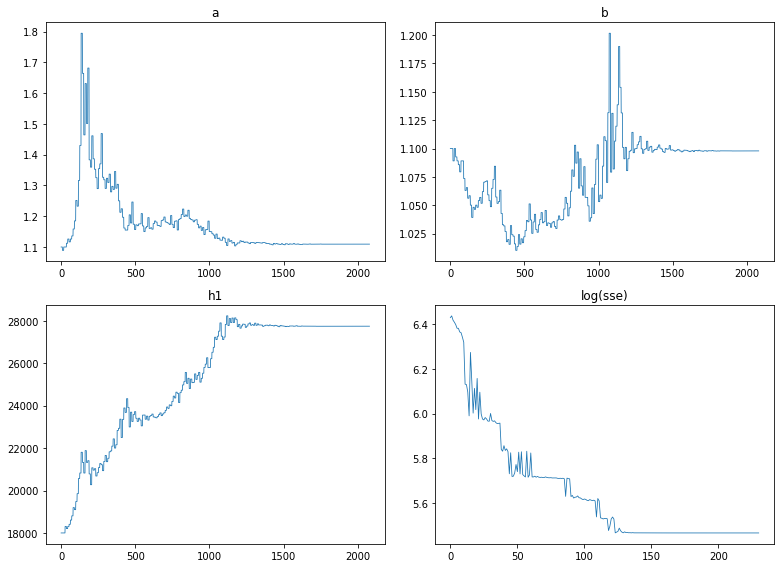

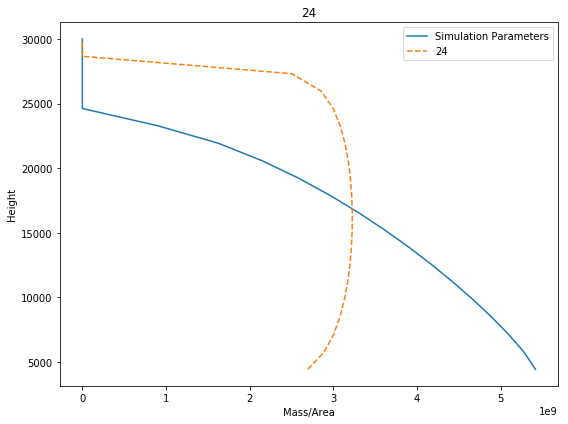

========LEFT OUT: (2037.0, 7565.0)========
a* = -2.19134	b* = -1.98093            	h1* = 3.20434
a = 1.11177	b = 1.13794	h1 = 28806.80094
Success: True, Optimization terminated successfully.
Iterations: 167
SSE: 229.77893250413746


Height  Suspended Mass
0    4430.75    2.645673e+09
1    5776.50    2.836477e+09
2    7122.25    2.943429e+09
3    8468.00    3.012863e+09
4    9813.75    3.059917e+09
5   11159.50    3.091412e+09
6   12505.25    3.110910e+09
7   13851.00    3.120379e+09
8   15196.75    3.120871e+09
9   16542.50    3.112811e+09
10  17888.25    3.096108e+09
11  19234.00    3.070150e+09
12  20579.75    3.033675e+09
13  21925.50    2.984459e+09
14  23271.25    2.918621e+09
15  24617.00    2.828942e+09
16  25962.75    2.699959e+09
17  27308.50    2.487352e+09
18  28654.25    1.825990e+09
19  30000.00    0.000000e+00

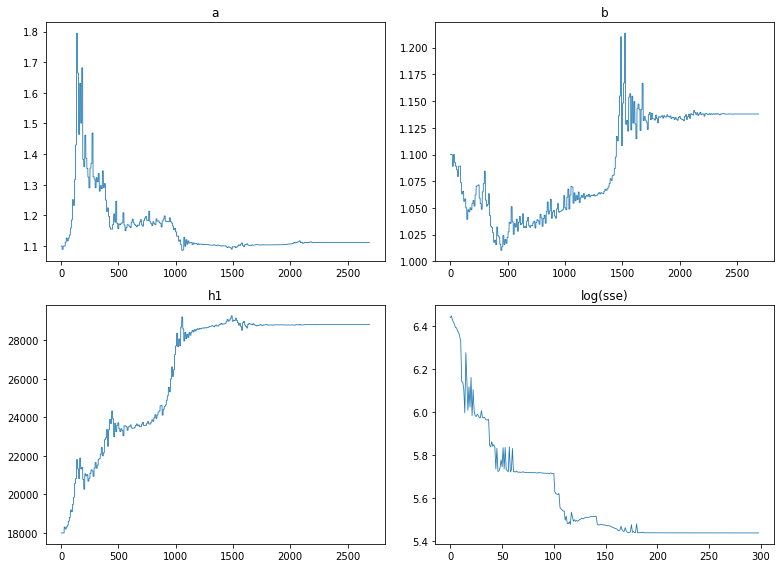

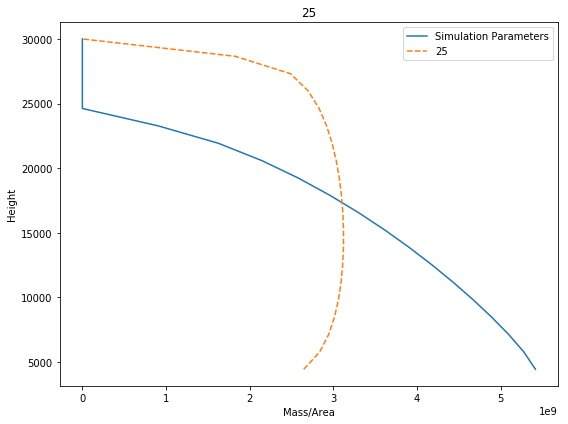

========LEFT OUT: (3352.0, 7167.0)========
a* = -2.20762	b* = -2.33162            	h1* = 2.54755
a = 1.10996	b = 1.09714	h1 = 27741.35812
Success: True, Optimization terminated successfully.
Iterations: 163
SSE: 236.64473556255822


Height  Suspended Mass
0    4430.75    2.688942e+09
1    5776.50    2.885191e+09
2    7122.25    2.998269e+09
3    8468.00    3.074409e+09
4    9813.75    3.128705e+09
5   11159.50    3.167959e+09
6   12505.25    3.195732e+09
7   13851.00    3.214002e+09
8   15196.75    3.223829e+09
9   16542.50    3.225643e+09
10  17888.25    3.219341e+09
11  19234.00    3.204254e+09
12  20579.75    3.178960e+09
13  21925.50    3.140821e+09
14  23271.25    3.084861e+09
15  24617.00    3.000594e+09
16  25962.75    2.859793e+09
17  27308.50    2.508693e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

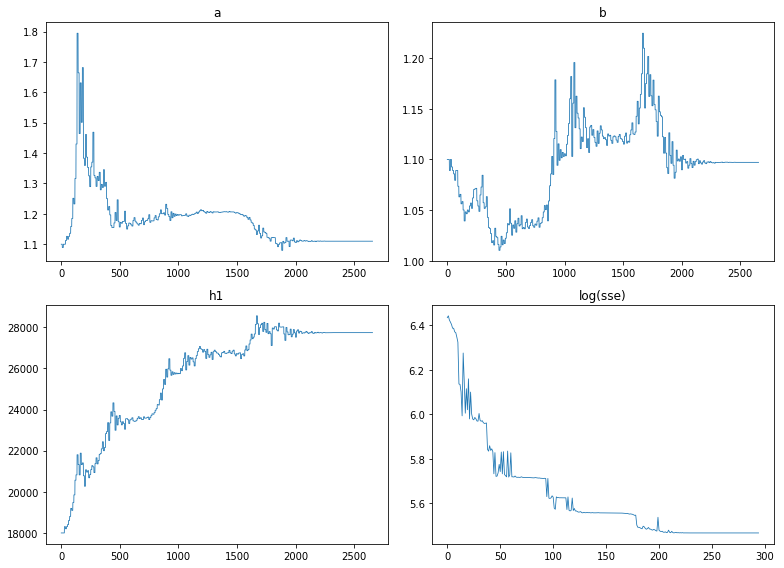

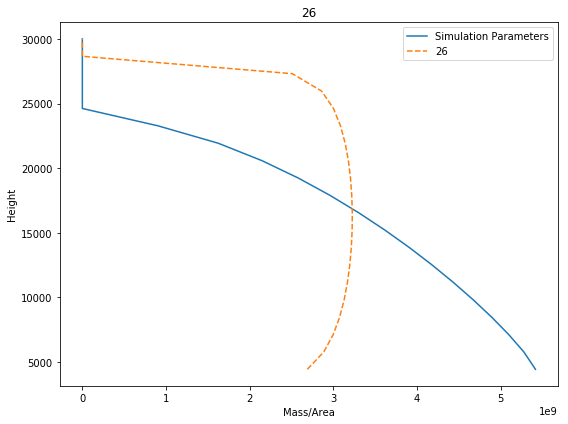

========LEFT OUT: (3066.0, 7419.0)========
a* = -2.06122	b* = -2.61975            	h1* = 2.17275
a = 1.12730	b = 1.07282	h1 = 26771.36770
Success: True, Optimization terminated successfully.
Iterations: 131
SSE: 252.49401975455555


Height  Suspended Mass
0    4430.75    2.688213e+09
1    5776.50    2.922937e+09
2    7122.25    3.062954e+09
3    8468.00    3.160830e+09
4    9813.75    3.233869e+09
5   11159.50    3.289933e+09
6   12505.25    3.333177e+09
7   13851.00    3.365946e+09
8   15196.75    3.389536e+09
9   16542.50    3.404521e+09
10  17888.25    3.410862e+09
11  19234.00    3.407839e+09
12  20579.75    3.393783e+09
13  21925.50    3.365353e+09
14  23271.25    3.315553e+09
15  24617.00    3.226829e+09
16  25962.75    3.027865e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

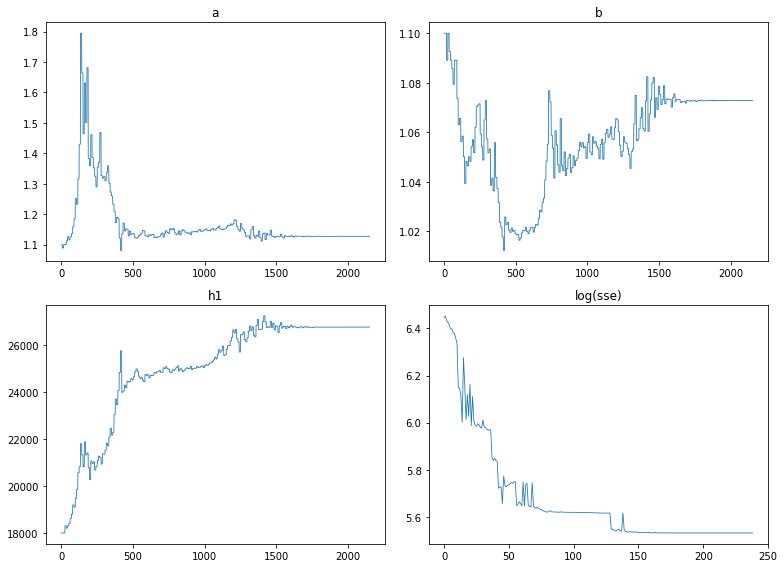

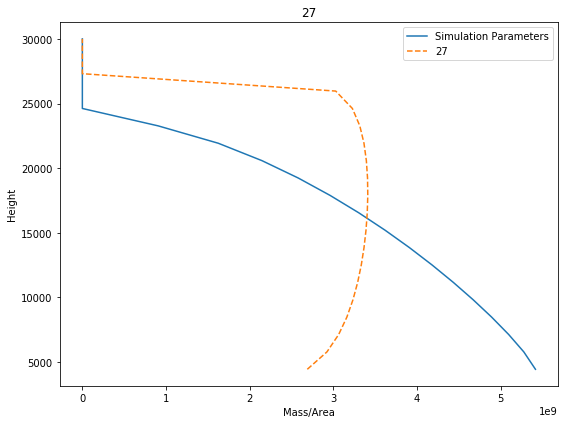

========LEFT OUT: (2287.0, 7844.0)========
a* = -2.19366	b* = -2.36054            	h1* = 2.54704
a = 1.11151	b = 1.09437	h1 = 27740.24359
Success: True, Optimization terminated successfully.
Iterations: 124
SSE: 237.37209916559112


Height  Suspended Mass
0    4430.75    2.673394e+09
1    5776.50    2.872056e+09
2    7122.25    2.987013e+09
3    8468.00    3.064802e+09
4    9813.75    3.120627e+09
5   11159.50    3.161353e+09
6   12505.25    3.190575e+09
7   13851.00    3.210297e+09
8   15196.75    3.221606e+09
9   16542.50    3.224953e+09
10  17888.25    3.220264e+09
11  19234.00    3.206903e+09
12  20579.75    3.183492e+09
13  21925.50    3.147462e+09
14  23271.25    3.093950e+09
15  24617.00    3.012691e+09
16  25962.75    2.876002e+09
17  27308.50    2.532560e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

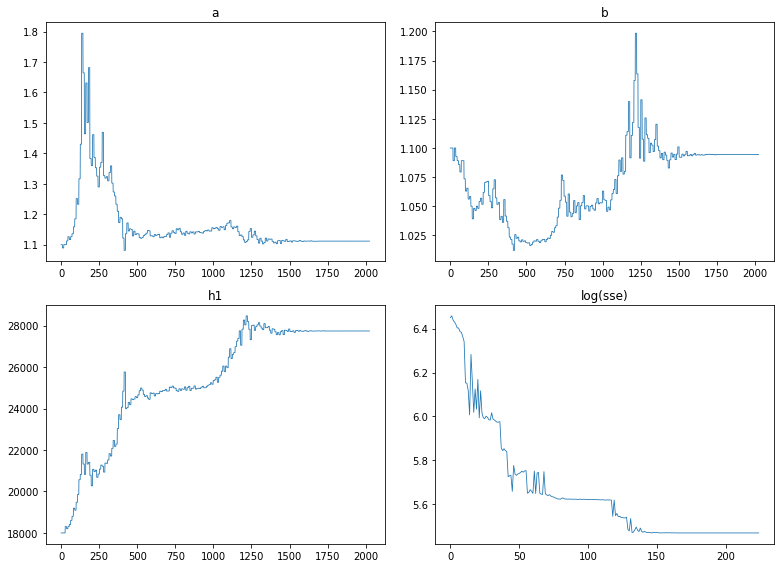

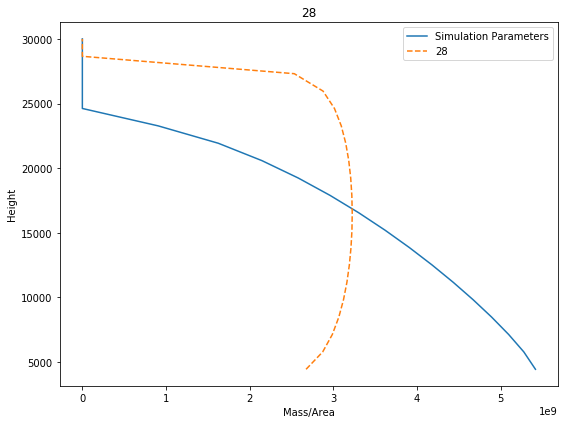

========LEFT OUT: (1907.0, 8096.0)========
a* = -2.19797	b* = -2.35403            	h1* = 2.54752
a = 1.11103	b = 1.09499	h1 = 27741.29611
Success: True, Optimization terminated successfully.
Iterations: 128
SSE: 238.08734933426885


Height  Suspended Mass
0    4430.75    2.677552e+09
1    5776.50    2.875462e+09
2    7122.25    2.989858e+09
3    8468.00    3.067171e+09
4    9813.75    3.122567e+09
5   11159.50    3.162891e+09
6   12505.25    3.191725e+09
7   13851.00    3.211068e+09
8   15196.75    3.221997e+09
9   16542.50    3.224960e+09
10  17888.25    3.219873e+09
11  19234.00    3.206094e+09
12  20579.75    3.182235e+09
13  21925.50    3.145713e+09
14  23271.25    3.091643e+09
15  24617.00    3.009714e+09
16  25962.75    2.872147e+09
17  27308.50    2.527330e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

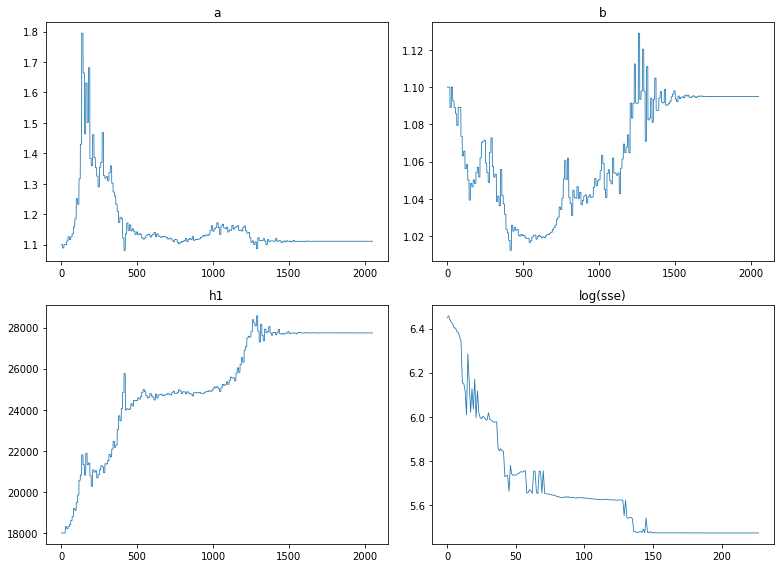

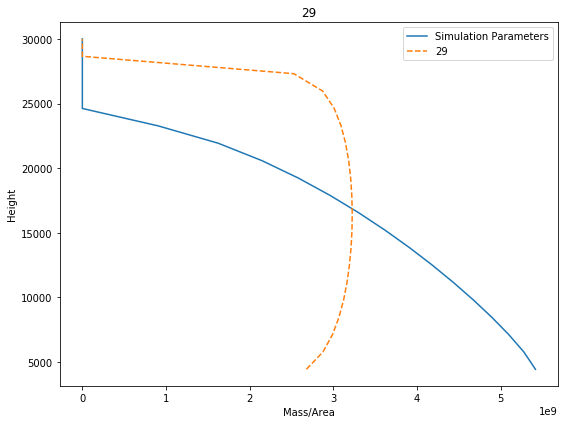

========LEFT OUT: (225.0, 8480.0)========
a* = -2.20120	b* = -2.35063            	h1* = 2.54764
a = 1.11067	b = 1.09531	h1 = 27741.54997
Success: True, Optimization terminated successfully.
Iterations: 118
SSE: 238.6212245354643


Height  Suspended Mass
0    4430.75    2.680328e+09
1    5776.50    2.877674e+09
2    7122.25    2.991662e+09
3    8468.00    3.068639e+09
4    9813.75    3.123740e+09
5   11159.50    3.163792e+09
6   12505.25    3.192372e+09
7   13851.00    3.211470e+09
8   15196.75    3.222159e+09
9   16542.50    3.224882e+09
10  17888.25    3.219553e+09
11  19234.00    3.205525e+09
12  20579.75    3.181404e+09
13  21925.50    3.144599e+09
14  23271.25    3.090212e+09
15  24617.00    3.007911e+09
16  25962.75    2.869858e+09
17  27308.50    2.524218e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

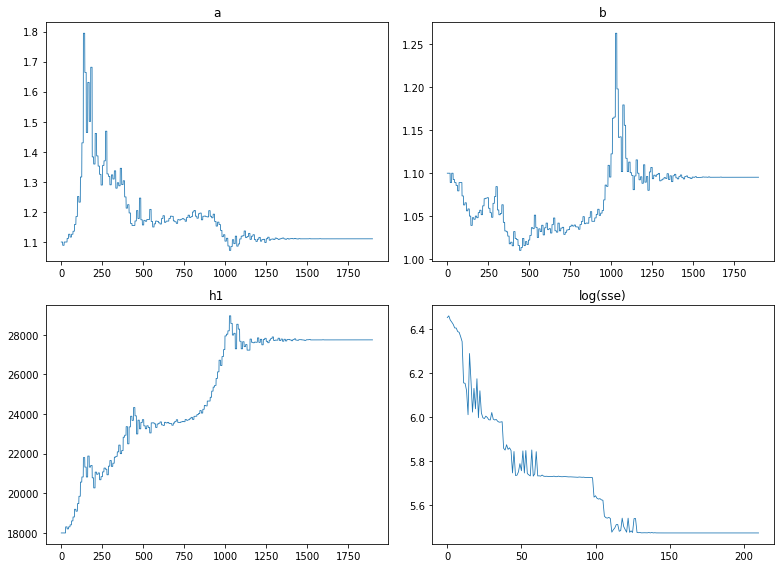

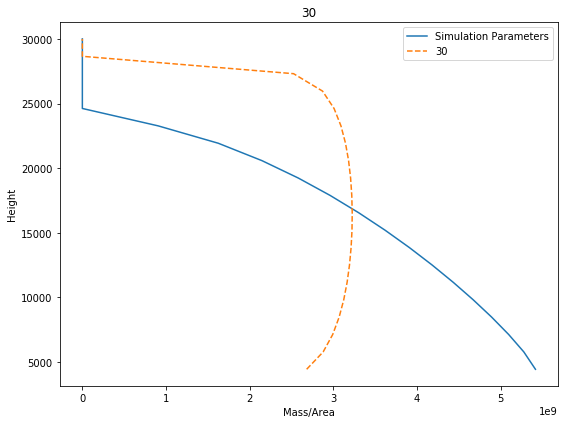

========LEFT OUT: (2424.0, 8963.0)========
a* = -2.19589	b* = -2.36788            	h1* = 2.54670
a = 1.11126	b = 1.09368	h1 = 27739.51290
Success: True, Optimization terminated successfully.
Iterations: 129
SSE: 235.65070473271084


Height  Suspended Mass
0    4430.75    2.672994e+09
1    5776.50    2.871250e+09
2    7122.25    2.986004e+09
3    8468.00    3.063690e+09
4    9813.75    3.119478e+09
5   11159.50    3.160215e+09
6   12505.25    3.189489e+09
7   13851.00    3.209302e+09
8   15196.75    3.220738e+09
9   16542.50    3.224251e+09
10  17888.25    3.219768e+09
11  19234.00    3.206661e+09
12  20579.75    3.183562e+09
13  21925.50    3.147918e+09
14  23271.25    3.094896e+09
15  24617.00    3.014288e+09
16  25962.75    2.878554e+09
17  27308.50    2.536941e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

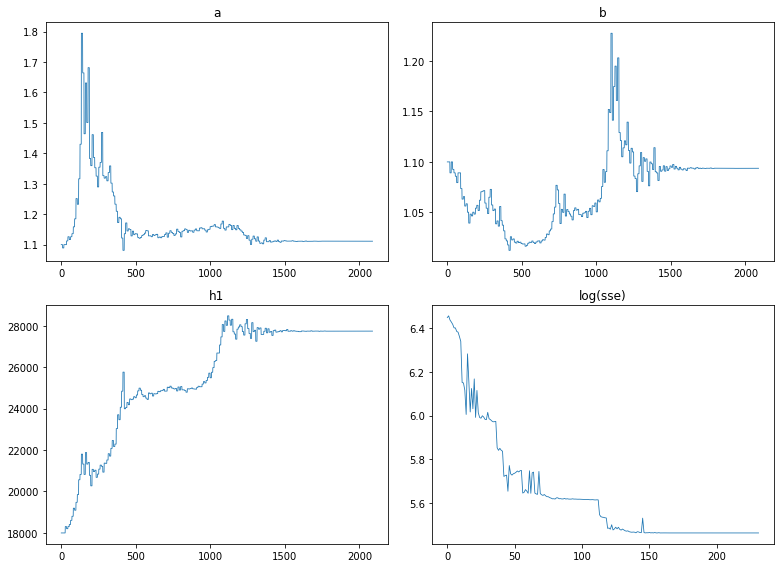

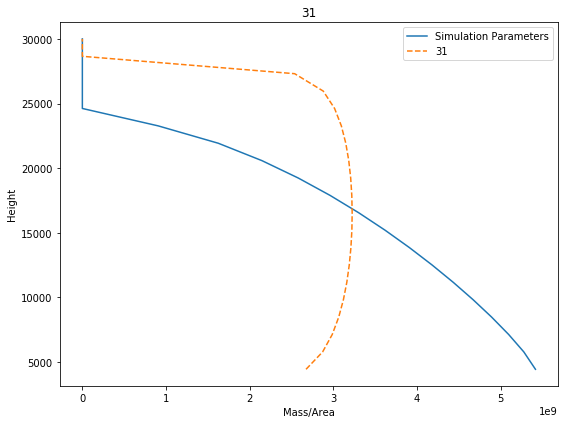

========LEFT OUT: (2665.0, 9054.0)========
a* = -2.19479	b* = -1.98824            	h1* = 3.20505
a = 1.11138	b = 1.13694	h1 = 28807.63525
Success: True, Optimization terminated successfully.
Iterations: 139
SSE: 231.92247309458816


Height  Suspended Mass
0    4430.75    2.645100e+09
1    5776.50    2.835269e+09
2    7122.25    2.941894e+09
3    8468.00    3.011153e+09
4    9813.75    3.058129e+09
5   11159.50    3.089619e+09
6   12505.25    3.109170e+09
7   13851.00    3.118745e+09
8   15196.75    3.119394e+09
9   16542.50    3.111539e+09
10  17888.25    3.095095e+09
11  19234.00    3.069453e+09
12  20579.75    3.033360e+09
13  21925.50    2.984608e+09
14  23271.25    2.919339e+09
15  24617.00    2.830378e+09
16  25962.75    2.702354e+09
17  27308.50    2.491197e+09
18  28654.25    1.834207e+09
19  30000.00    0.000000e+00

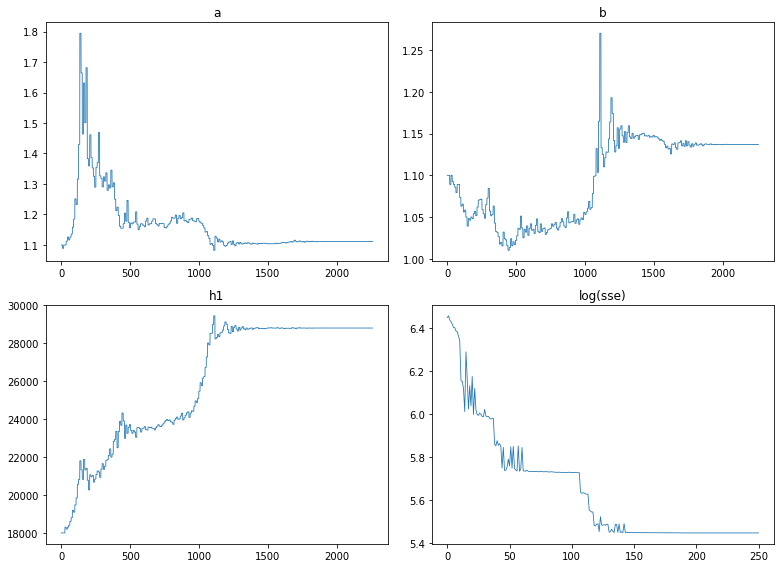

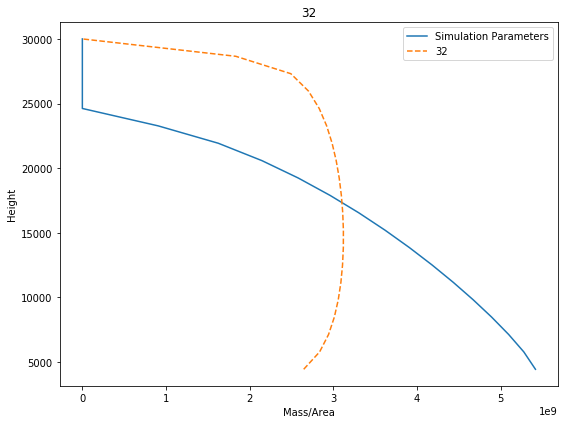

========LEFT OUT: (2979.0, 9056.0)========
a* = -2.20446	b* = -2.34675            	h1* = 2.54774
a = 1.11031	b = 1.09568	h1 = 27741.77128
Success: True, Optimization terminated successfully.
Iterations: 121
SSE: 239.25755347899815


Height  Suspended Mass
0    4430.75    2.683243e+09
1    5776.50    2.880021e+09
2    7122.25    2.993595e+09
3    8468.00    3.070226e+09
4    9813.75    3.125021e+09
5   11159.50    3.164790e+09
6   12505.25    3.193102e+09
7   13851.00    3.211940e+09
8   15196.75    3.222372e+09
9   16542.50    3.224839e+09
10  17888.25    3.219248e+09
11  19234.00    3.204946e+09
12  20579.75    3.180537e+09
13  21925.50    3.143418e+09
14  23271.25    3.088677e+09
15  24617.00    3.005954e+09
16  25962.75    2.867344e+09
17  27308.50    2.520729e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

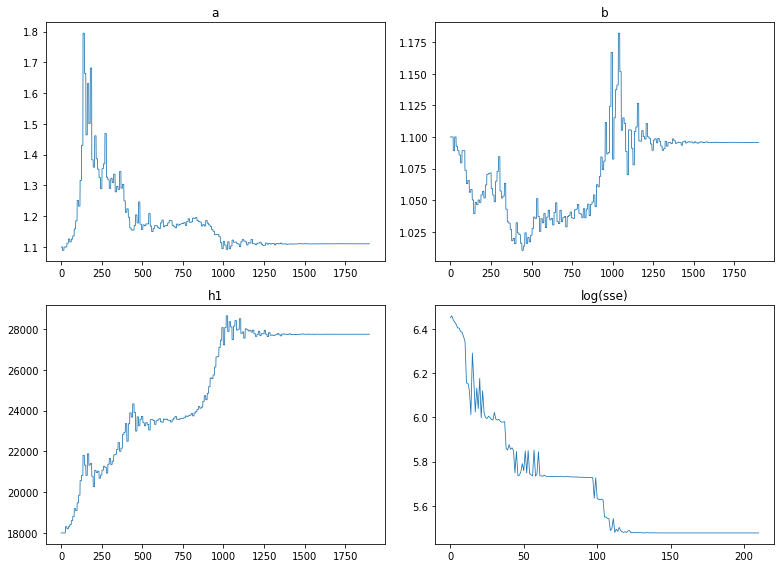

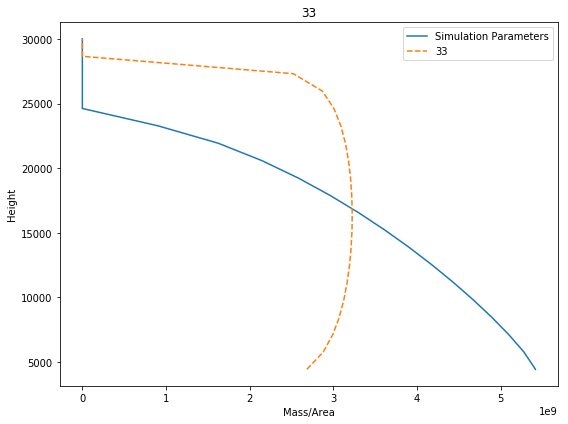

========LEFT OUT: (3133.0, 9522.0)========
a* = -2.20353	b* = -2.34853            	h1* = 2.54771
a = 1.11041	b = 1.09551	h1 = 27741.70370
Success: True, Optimization terminated successfully.
Iterations: 117
SSE: 238.95245044835403


Height  Suspended Mass
0    4430.75    2.682243e+09
1    5776.50    2.879182e+09
2    7122.25    2.992880e+09
3    8468.00    3.069620e+09
4    9813.75    3.124513e+09
5   11159.50    3.164378e+09
6   12505.25    3.192783e+09
7   13851.00    3.211713e+09
8   15196.75    3.222240e+09
9   16542.50    3.224803e+09
10  17888.25    3.219313e+09
11  19234.00    3.205121e+09
12  20579.75    3.180829e+09
13  21925.50    3.143841e+09
14  23271.25    3.089252e+09
15  24617.00    3.006715e+09
16  25962.75    2.868359e+09
17  27308.50    2.522214e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

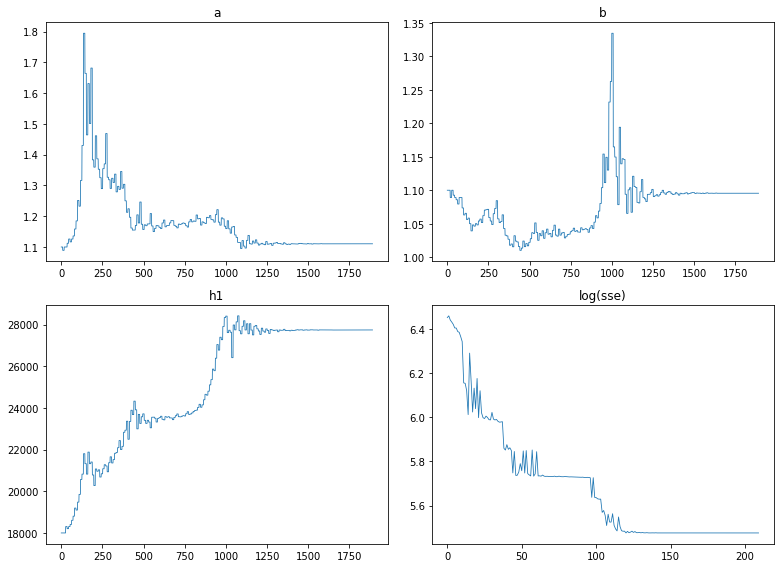

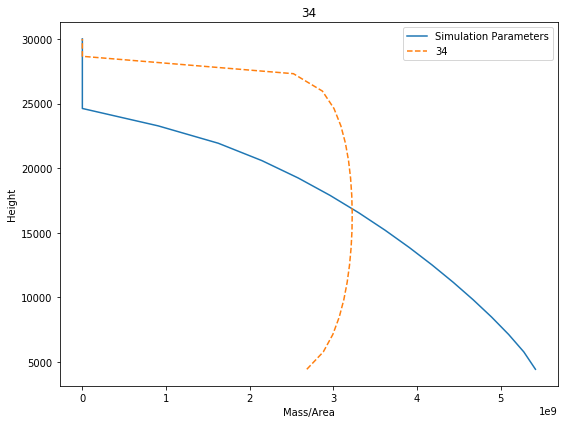

========LEFT OUT: (5500.0, 8723.0)========
a* = -2.19613	b* = -2.36124            	h1* = 2.54695
a = 1.11123	b = 1.09430	h1 = 27740.05624
Success: True, Optimization terminated successfully.
Iterations: 147
SSE: 237.18382046997246


Height  Suspended Mass
0    4430.75    2.674732e+09
1    5776.50    2.872956e+09
2    7122.25    2.987628e+09
3    8468.00    3.065203e+09
4    9813.75    3.120859e+09
5   11159.50    3.161445e+09
6   12505.25    3.190550e+09
7   13851.00    3.210173e+09
8   15196.75    3.221398e+09
9   16542.50    3.224675e+09
10  17888.25    3.219928e+09
11  19234.00    3.206521e+09
12  20579.75    3.183078e+09
13  21925.50    3.147029e+09
14  23271.25    3.093516e+09
15  24617.00    3.012280e+09
16  25962.75    2.875656e+09
17  27308.50    2.532371e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

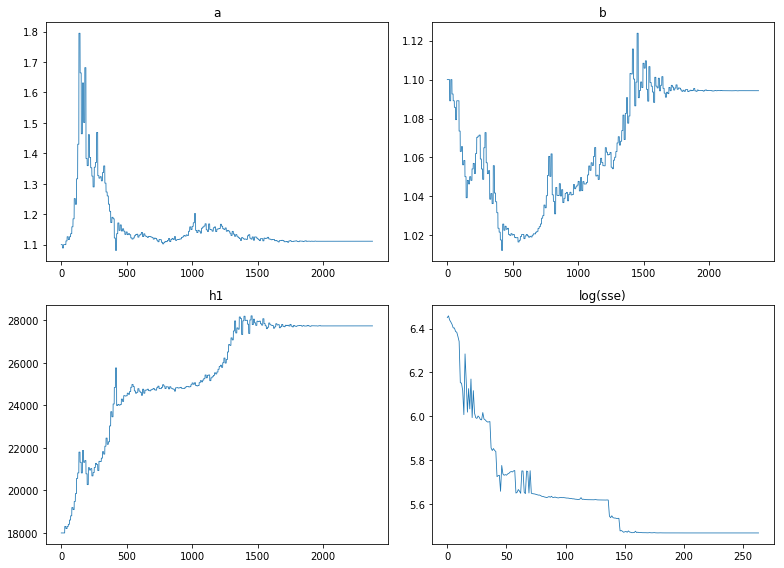

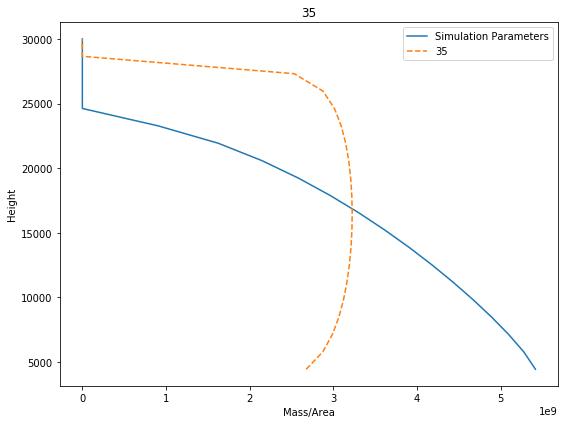

========LEFT OUT: (4617.0, 10199.0)========
a* = -2.18642	b* = -2.37276            	h1* = 2.54609
a = 1.11232	b = 1.09322	h1 = 27738.18261
Success: True, Optimization terminated successfully.
Iterations: 132
SSE: 236.14654434170453


Height  Suspended Mass
0    4430.75    2.666123e+09
1    5776.50    2.866048e+09
2    7122.25    2.981959e+09
3    8468.00    3.060565e+09
4    9813.75    3.117133e+09
5   11159.50    3.158560e+09
6   12505.25    3.188460e+09
7   13851.00    3.208853e+09
8   15196.75    3.220835e+09
9   16542.50    3.224871e+09
10  17888.25    3.220896e+09
11  19234.00    3.208288e+09
12  20579.75    3.185689e+09
13  21925.50    3.150555e+09
14  23271.25    3.098067e+09
15  24617.00    3.018040e+09
16  25962.75    2.882977e+09
17  27308.50    2.542081e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

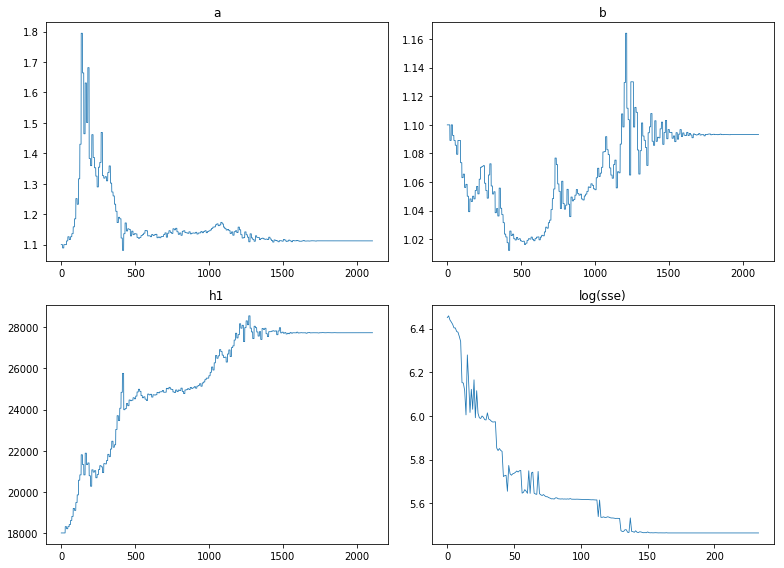

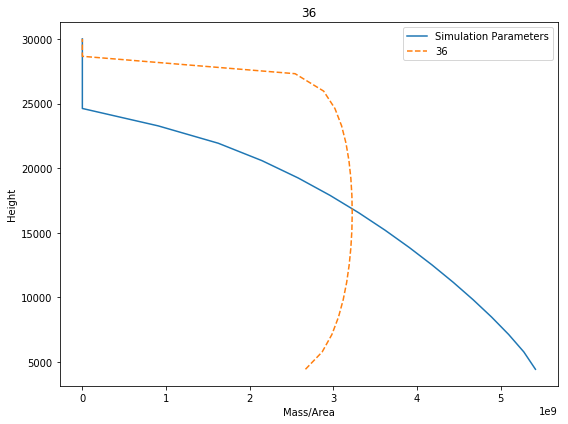

========LEFT OUT: (5132.0, 11365.0)========
a* = -2.16736	b* = -2.03529            	h1* = 3.20377
a = 1.11448	b = 1.13064	h1 = 28806.13856
Success: True, Optimization terminated successfully.
Iterations: 136
SSE: 226.6404207622369


Height  Suspended Mass
0    4430.75    2.612381e+09
1    5776.50    2.807219e+09
2    7122.25    2.917554e+09
3    8468.00    2.990106e+09
4    9813.75    3.040161e+09
5   11159.50    3.074620e+09
6   12505.25    3.097097e+09
7   13851.00    3.109603e+09
8   15196.75    3.113227e+09
9   16542.50    3.108434e+09
10  17888.25    3.095176e+09
11  19234.00    3.072895e+09
12  20579.75    3.040402e+09
13  21925.50    2.995575e+09
14  23271.25    2.934689e+09
15  24617.00    2.850789e+09
16  25962.75    2.728938e+09
17  27308.50    2.526159e+09
18  28654.25    1.884974e+09
19  30000.00    0.000000e+00

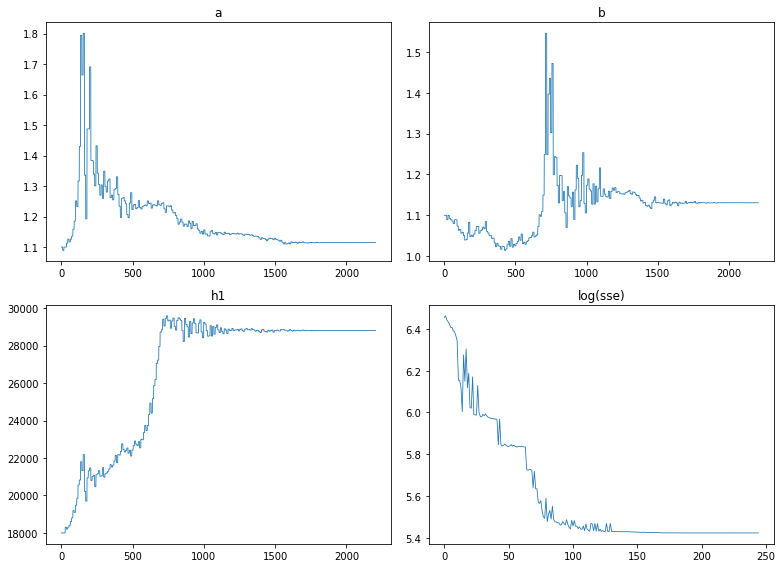

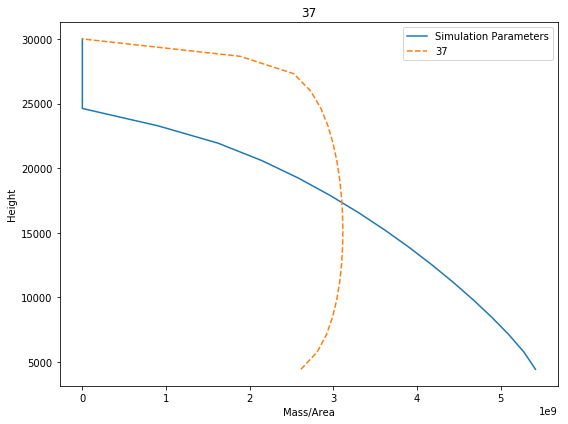

In [13]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 18000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h1" : True
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []
sse_list = []
for i in range(len(df)):
    loo_df = df.copy()
    loo_df = loo_df.drop(index=i)
    row = df.iloc[i]
    print("========LEFT OUT: (%s, %s)========"%(str(row["Easting"]),
                                                str(row["Northing"])))
    out = gaussian_stack_inversion(
        loo_df, len(loo_df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=i)
    ax1.legend()
    ax1.set_title("%s"%str(i))
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

Coordinate Removed  Distance from Vent         a         b  Column Height  \
0        (1499, 1506)         2124.861643  1.112109  1.136283   28806.631551   
1        (1957, 1997)         2796.043276  1.127462  1.072606   26771.742599   
2        (1787, 2173)         2813.413940  1.120006  1.076594   26773.829496   
3        (-770, 3082)         3176.731654  1.112392  1.135834   28806.740455   
4       (-1673, 3152)         3568.477687  1.127546  1.072462   26772.158356   
5        (-637, 4876)         4917.432765  1.111033  1.094992   27741.240349   
6       (-1268, 5048)         5204.817768  1.112009  1.093897   27739.216818   
7       (-2101, 5517)         5903.515055  1.127756  1.072342   26771.579893   
8       (-2250, 5771)         6194.105343  1.112482  1.135614   28806.775748   
9       (-2272, 5925)         6345.676402  1.108303  1.097796   27739.469534   
10         (32, 6398)         6398.080025  1.101444  1.104913   27741.481218   
11       (-337, 6683)         6691.491463  1.111099  1.096453   27741.098169   
12       (2519, 6318)         6801.653108  1.112043  1.094667   27738.827042   
13      (-1439, 6652)         6805.866954  1.126672  1.072917   26774.474950   
14       (5823, 3944)         7032.955638  1.111137  1.094870   27741.136883   
15       (4688, 5396)         7148.017907  1.111304  1.095071   27739.325771   
16        (918, 7180)         7238.447624  1.093411  1.115223   27778.876283   
17       (4337, 6035)         7431.742326  1.101633  1.107557   27765.980739   
18       (2019, 7255)         7530.696249  1.100980  1.107860   27766.210646   
19       (-586, 7588)         7610.593932  1.127526  1.072709   26771.265900   
20       (-387, 7656)         7665.774912  1.108244  1.098404   27744.568214   
21       (-555, 7666)         7686.064077  1.105924  1.101106   27749.799295   
22       (3512, 6869)         7714.745945  1.106608  1.100551   27747.972570   
23       (3226, 7110)         7807.635750  1.111347  1.138921   28807.149884   
24       (1154, 7735)         7820.610015  1.109308  1.097926   27742.633334   
25       (2037, 7565)         7834.449183  1.111767  1.137941   28806.800936   
26       (3352, 7167)         7912.129486  1.109962  1.097138   27741.358119   
27       (3066, 7419)         8027.572298  1.127298  1.072821   26771.367695   
28       (2287, 7844)         8170.600039  1.111508  1.094369   27740.243594   
29       (1907, 8096)         8317.563646  1.111028  1.094986   27741.296107   
30        (225, 8480)         8482.984439  1.110670  1.095309   27741.549974   
31       (2424, 8963)         9284.995692  1.111260  1.093679   27739.512902   
32       (2665, 9054)         9438.068711  1.111382  1.136937   28807.635249   
33       (2979, 9056)         9533.392733  1.110310  1.095680   27741.771278   
34       (3133, 9522)        10024.179418  1.110413  1.095509   27741.703699   
35       (5500, 8723)        10312.164128  1.111233  1.094303   27740.056244   
36      (4617, 10199)        11195.369132  1.112319  1.093223   27738.182611   
37      (5132, 11365)        12469.989936  1.114480  1.130643   28806.138556   

    Goodness of Fit  
0        230.245250  
1        252.583722  
2        254.562295  
3        229.881863  
4        252.663385  
5        238.087489  
6        236.912339  
7        252.593306  
8        229.785303  
9        241.390290  
10       258.406063  
11       236.958591  
12       237.003593  
13       253.364735  
14       237.922285  
15       237.343985  
16       241.111170  
17       242.580107  
18       241.966851  
19       252.486481  
20       239.087612  
21       235.046931  
22       234.999971  
23       229.644981  
24       236.326459  
25       229.778933  
26       236.644736  
27       252.494020  
28       237.372099  
29       238.087349  
30       238.621225  
31       235.650705  
32       231.922473  
33       239.257553  
34       238.952450  
35       237.183820  
36       236.146544  
37       226.640421

\begin{tabular}{lrrrrr}
\toprule
Coordinate Removed &  Distance from Vent &    a &    b &  Column Height &  Goodness of Fit \\
\midrule
      (1499, 1506) &             2124.86 & 1.11 & 1.14 &       28806.63 &           230.25 \\
      (1957, 1997) &             2796.04 & 1.13 & 1.07 &       26771.74 &           252.58 \\
      (1787, 2173) &             2813.41 & 1.12 & 1.08 &       26773.83 &           254.56 \\
      (-770, 3082) &             3176.73 & 1.11 & 1.14 &       28806.74 &           229.88 \\
     (-1673, 3152) &             3568.48 & 1.13 & 1.07 &       26772.16 &           252.66 \\
      (-637, 4876) &             4917.43 & 1.11 & 1.09 &       27741.24 &           238.09 \\
     (-1268, 5048) &             5204.82 & 1.11 & 1.09 &       27739.22 &           236.91 \\
     (-2101, 5517) &             5903.52 & 1.13 & 1.07 &       26771.58 &           252.59 \\
     (-2250, 5771) &             6194.11 & 1.11 & 1.14 &       28806.78 &           229.79 \\
     (-2272, 5925)

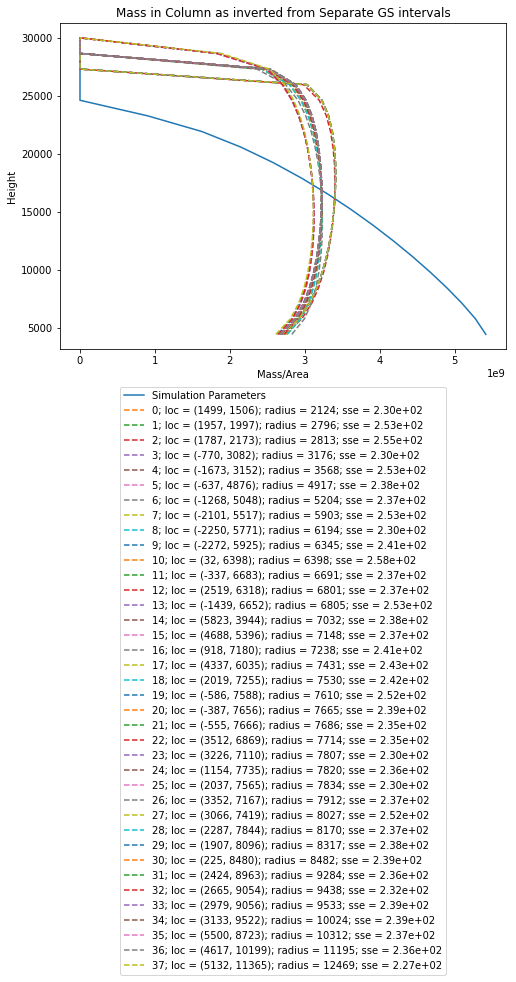

In [14]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                            config["VENT_ELEVATION"], 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"],
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

table = pd.DataFrame(columns=[
    "Coordinate Removed", 
    "Distance from Vent", 
    "a", 
    "b", 
    "Column Height", 
    "Goodness of Fit"
])

for i, mass, sse in zip(range(len(df)), inverted_masses_list, sse_list):
    row=df.iloc[i]
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="%d; loc = (%d, %d); radius = %d; sse = %.2e"%(
             i, 
             row["Easting"], 
             row["Northing"], 
             row["radius"],
             sse))
    table = table.append({
        "Coordinate Removed": "(%d, %d)"%(row["Easting"], row["Northing"]),
        "Distance from Vent": row["radius"],
        "a": params_list[i]["a"],
        "b": params_list[i]["b"],
        "Column Height": params_list[i]["h1"],
        "Goodness of Fit": sse,
    }, ignore_index=True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
# plt.show()
plt.savefig("data/colima/PNT_CV_%s_%s.png"%(file_tag, err_type), dpi=300, bbox_inches='tight')
display(table)
print(table.to_latex(index=False, float_format="%.2f"))
file = open("data/colima/PNT_CV_%s_%s.tex"%(file_tag, err_type), "w")
file.write(table.to_latex(index=False, float_format="%.2f"))
file.close()

## Left out Sections

In [15]:
sectors = [
    (0, 2000),
    (2000, 4000),
    (4000, 6000),
    (6000, 8000),
    (8000, 10000),
    (10000, 12000),
    (12000, 14000),
]

# sectors = [
#     (0, 3000),
#     (3000, 6000),
#     (6000, 9000),
#     (9000, 12000),
#     (12000, 15000),
# ]

# sectors = [
#     (0, 4000),
#     (4000, 8000),
#     (8000, 12000),
#     (12000, 16000),
# ]

========LEFT OUT BETWEEN: 0 m and 2000 m========
Points left out: 0
a* = -2.21051	b* = -2.33692            	h1* = 2.54809
a = 1.10964	b = 1.09663	h1 = 27742.53485
Success: True, Optimization terminated successfully.
Iterations: 140
SSE: 241.1655535840739


Height  Suspended Mass
0    4430.75    2.689288e+09
1    5776.50    2.885017e+09
2    7122.25    2.997802e+09
3    8468.00    3.073758e+09
4    9813.75    3.127938e+09
5   11159.50    3.167128e+09
6   12505.25    3.194879e+09
7   13851.00    3.213162e+09
8   15196.75    3.223038e+09
9   16542.50    3.224935e+09
10  17888.25    3.218753e+09
11  19234.00    3.203828e+09
12  20579.75    3.178745e+09
13  21925.50    3.140882e+09
14  23271.25    3.085287e+09
15  24617.00    3.001531e+09
16  25962.75    2.861537e+09
17  27308.50    2.512495e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

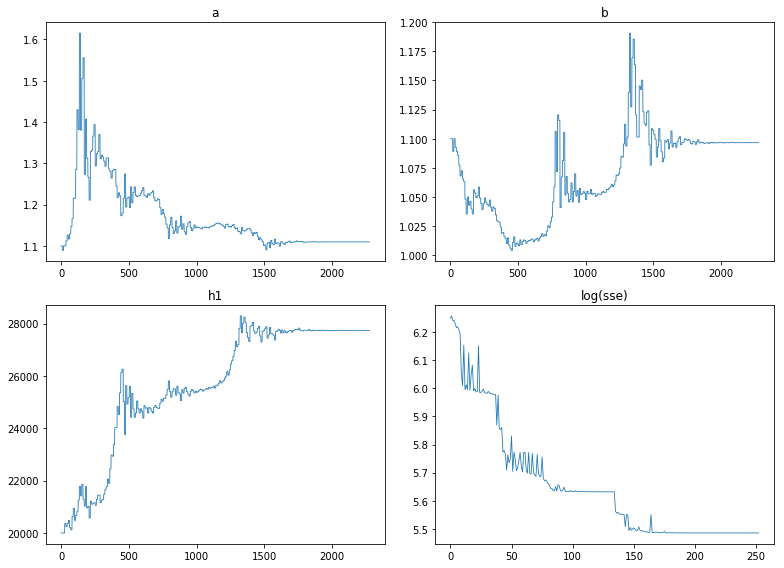

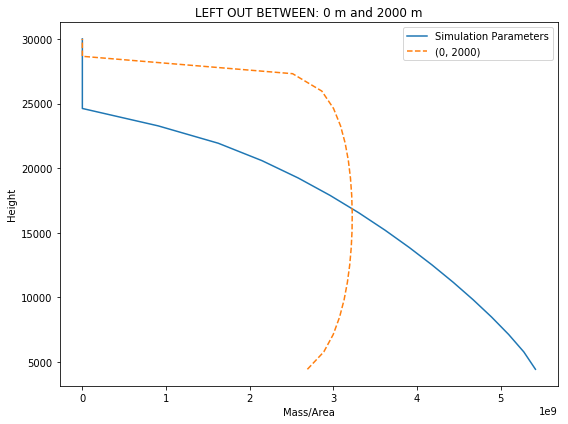

========LEFT OUT BETWEEN: 2000 m and 4000 m========
Points left out: 5
a* = -2.16470	b* = -2.05196            	h1* = 3.21517
a = 1.11478	b = 1.12848	h1 = 28819.40817
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 271.8246593469811


Height  Suspended Mass
0    4430.75    2.603866e+09
1    5776.50    2.799014e+09
2    7122.25    2.909777e+09
3    8468.00    2.982826e+09
4    9813.75    3.033432e+09
5   11159.50    3.068493e+09
6   12505.25    3.091624e+09
7   13851.00    3.104841e+09
8   15196.75    3.109240e+09
9   16542.50    3.105293e+09
10  17888.25    3.092967e+09
11  19234.00    3.071724e+09
12  20579.75    3.040401e+09
13  21925.50    2.996919e+09
14  23271.25    2.937624e+09
15  24617.00    2.855696e+09
16  25962.75    2.736499e+09
17  27308.50    2.538071e+09
18  28654.25    1.921693e+09
19  30000.00    0.000000e+00

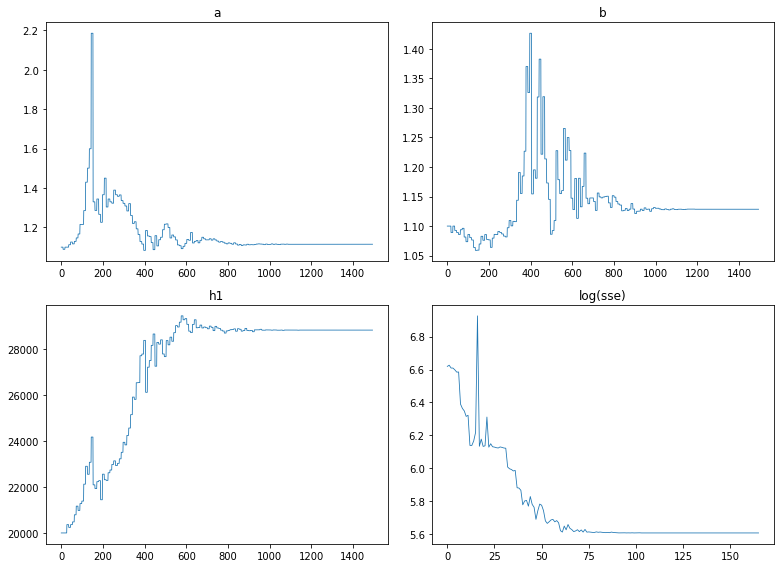

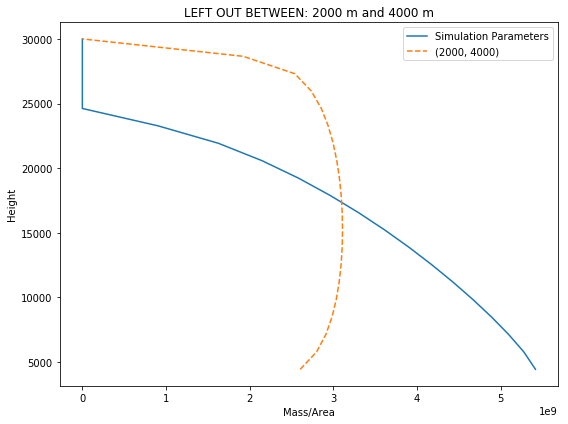

========LEFT OUT BETWEEN: 4000 m and 6000 m========
Points left out: 3
a* = -2.16430	b* = -2.40948            	h1* = 2.54470
a = 1.11483	b = 1.08986	h1 = 27735.15534
Success: True, Optimization terminated successfully.
Iterations: 82
SSE: 229.8644184695346


Height  Suspended Mass
0    4430.75    2.644001e+09
1    5776.50    2.847788e+09
2    7122.25    2.966608e+09
3    8468.00    3.047698e+09
4    9813.75    3.106522e+09
5   11159.50    3.150072e+09
6   12505.25    3.182024e+09
7   13851.00    3.204440e+09
8   15196.75    3.218453e+09
9   16542.50    3.224561e+09
10  17888.25    3.222733e+09
11  19234.00    3.212391e+09
12  20579.75    3.192233e+09
13  21925.50    3.159798e+09
14  23271.25    3.110402e+09
15  24617.00    3.034122e+09
16  25962.75    2.904090e+09
17  27308.50    2.572065e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

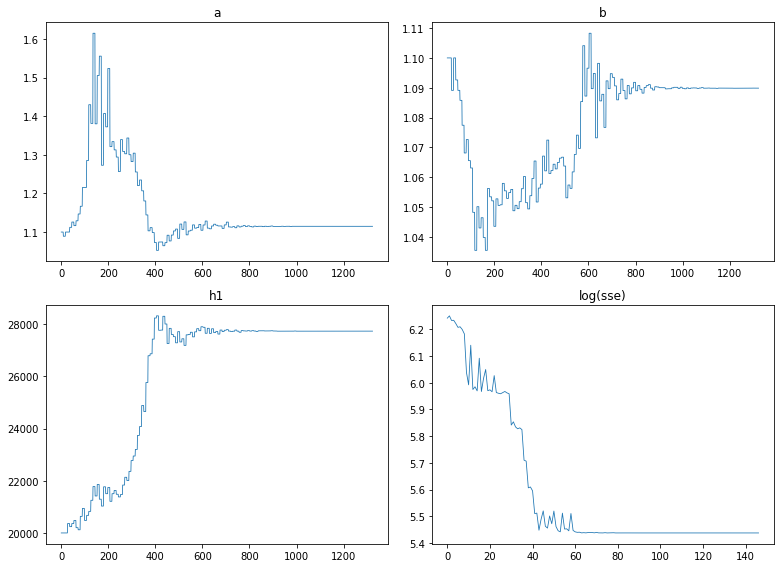

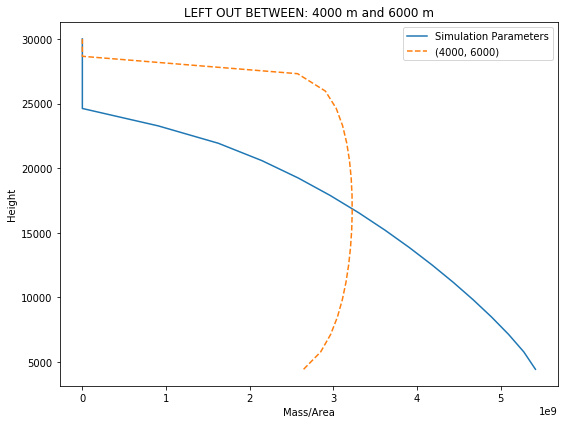

========LEFT OUT BETWEEN: 6000 m and 8000 m========
Points left out: 19
a* = -2.06017	b* = -2.08543            	h1* = 3.20171
a = 1.12743	b = 1.12425	h1 = 28803.73156
Success: True, Optimization terminated successfully.
Iterations: 109
SSE: 155.98279126043937


Height  Suspended Mass
0    4430.75    2.527651e+09
1    5776.50    2.741656e+09
2    7122.25    2.865517e+09
3    8468.00    2.948943e+09
4    9813.75    3.008299e+09
5   11159.50    3.051019e+09
6   12505.25    3.081022e+09
7   13851.00    3.100519e+09
8   15196.75    3.110739e+09
9   16542.50    3.112253e+09
10  17888.25    3.105102e+09
11  19234.00    3.088809e+09
12  20579.75    3.062265e+09
13  21925.50    3.023440e+09
14  23271.25    2.968729e+09
15  24617.00    2.891359e+09
16  25962.75    2.776719e+09
17  27308.50    2.582606e+09
18  28654.25    1.953355e+09
19  30000.00    0.000000e+00

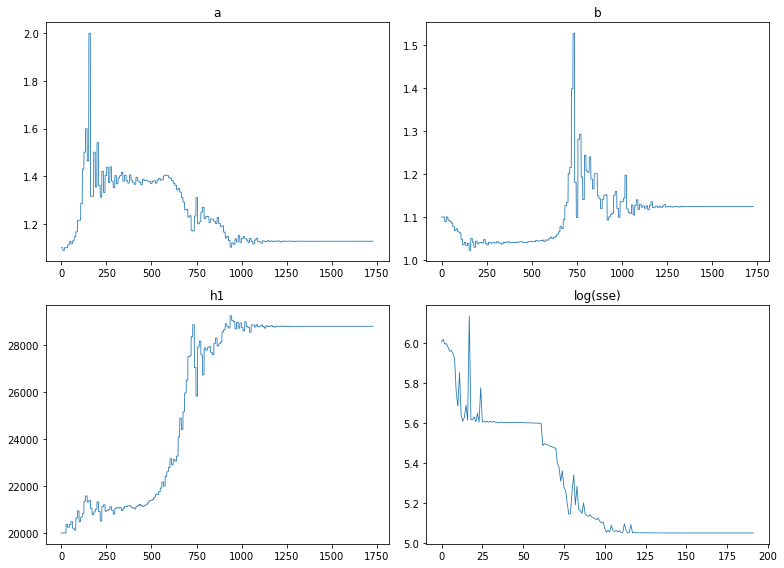

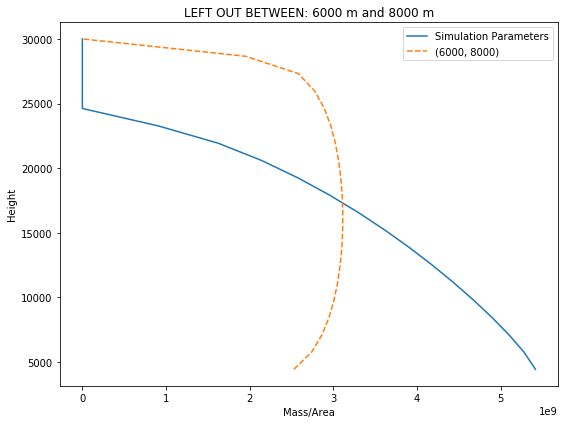

========LEFT OUT BETWEEN: 8000 m and 10000 m========
Points left out: 7
a* = -2.09927	b* = -2.09622            	h1* = 3.19988
a = 1.12255	b = 1.12292	h1 = 28801.58698
Success: True, Optimization terminated successfully.
Iterations: 116
SSE: 204.76137276306918


Height  Suspended Mass
0    4430.75    2.550203e+09
1    5776.50    2.756973e+09
2    7122.25    2.876052e+09
3    8468.00    2.955877e+09
4    9813.75    3.012360e+09
5   11159.50    3.052713e+09
6   12505.25    3.080734e+09
7   13851.00    3.098559e+09
8   15196.75    3.107369e+09
9   16542.50    3.107706e+09
10  17888.25    3.099595e+09
11  19234.00    3.082551e+09
12  20579.75    3.055470e+09
13  21925.50    3.016339e+09
14  23271.25    2.961590e+09
15  24617.00    2.884525e+09
16  25962.75    2.770686e+09
17  27308.50    2.578267e+09
18  28654.25    1.952431e+09
19  30000.00    0.000000e+00

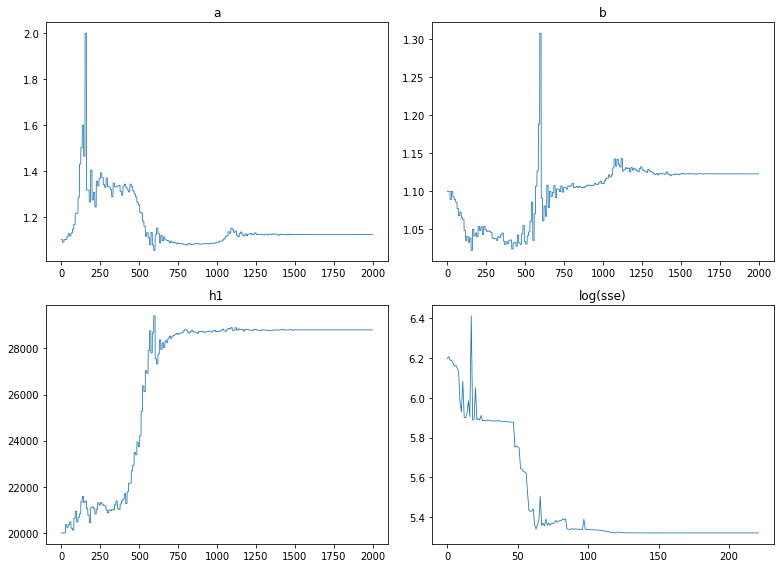

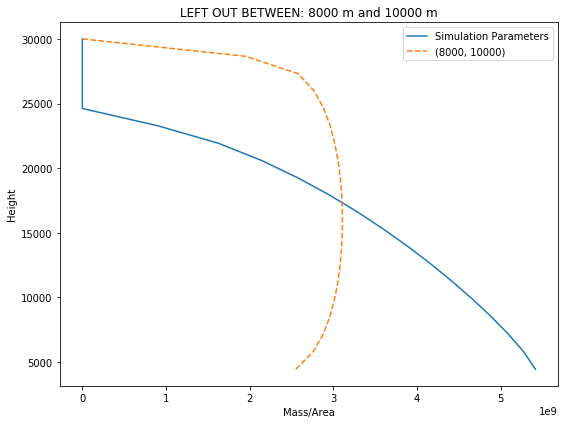

========LEFT OUT BETWEEN: 10000 m and 12000 m========
Points left out: 3
a* = -2.24860	b* = -2.30018            	h1* = 2.54458
a = 1.10555	b = 1.10024	h1 = 27734.89518
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 237.4178626930969


Height  Suspended Mass
0    4430.75    2.721598e+09
1    5776.50    2.910765e+09
2    7122.25    3.018837e+09
3    8468.00    3.090916e+09
4    9813.75    3.141692e+09
5   11159.50    3.177771e+09
6   12505.25    3.202597e+09
7   13851.00    3.218071e+09
8   15196.75    3.225196e+09
9   16542.50    3.224354e+09
10  17888.25    3.215398e+09
11  19234.00    3.197610e+09
12  20579.75    3.169508e+09
13  21925.50    3.128371e+09
14  23271.25    3.069086e+09
15  24617.00    2.980898e+09
16  25962.75    2.834854e+09
17  27308.50    2.472481e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

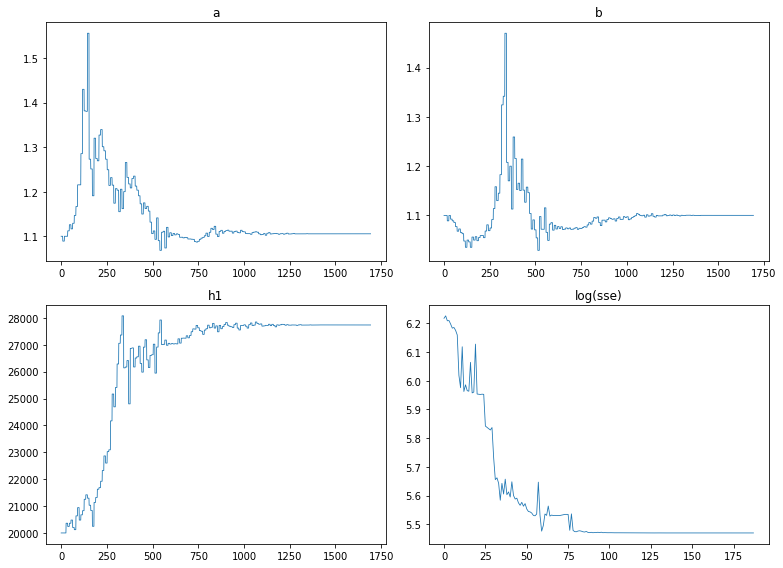

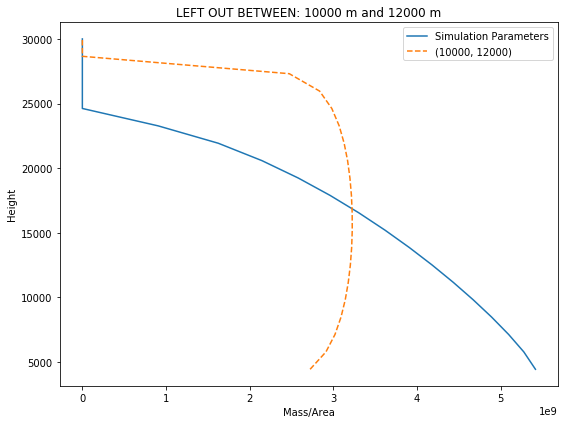

========LEFT OUT BETWEEN: 12000 m and 14000 m========
Points left out: 1
a* = -2.28825	b* = -2.25467            	h1* = 2.54760
a = 1.10144	b = 1.10491	h1 = 27741.46570
Success: True, Optimization terminated successfully.
Iterations: 109
SSE: 258.40606346060645


Height  Suspended Mass
0    4430.75    2.756254e+09
1    5776.50    2.938647e+09
2    7122.25    3.041796e+09
3    8468.00    3.109777e+09
4    9813.75    3.156911e+09
5   11159.50    3.189624e+09
6   12505.25    3.211253e+09
7   13851.00    3.223623e+09
8   15196.75    3.227681e+09
9   16542.50    3.223756e+09
10  17888.25    3.211651e+09
11  19234.00    3.190589e+09
12  20579.75    3.159017e+09
13  21925.50    3.114108e+09
14  23271.25    3.050583e+09
15  24617.00    2.957382e+09
16  25962.75    2.804856e+09
17  27308.50    2.432492e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

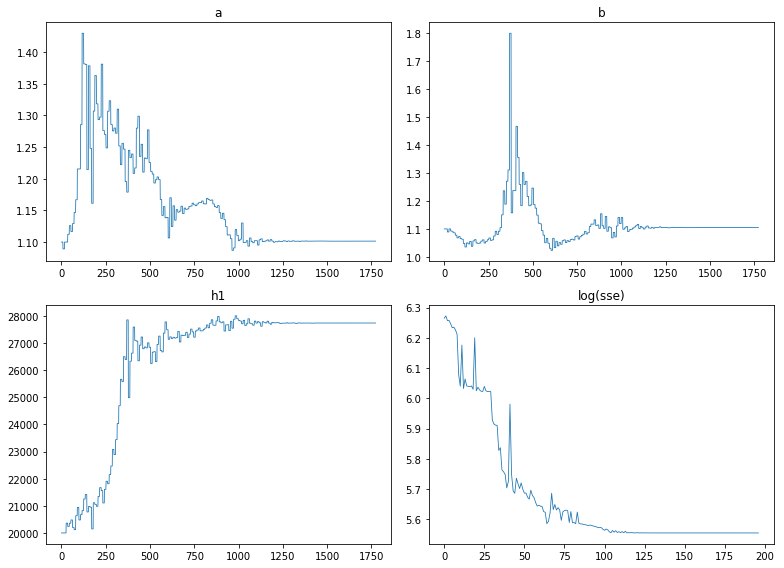

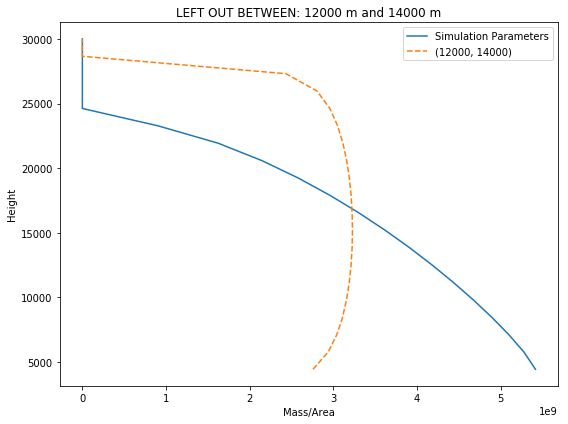

In [16]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 20000
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

inverted_masses_list = []
params_list = []
sse_list = []
numpoints_list = []
for i, sec in enumerate(sectors):
    loo_df = df.copy()
    loo_df = loo_df[(loo_df["radius"]<=sec[0])|(loo_df["radius"]>sec[1])]
    
    print("========LEFT OUT BETWEEN: %s m and %s m========"%(str(sec[0]),
                                                             str(sec[1])))
    
    num_points = len(df) - len(loo_df)
    print("Points left out: %s"%(num_points))
    numpoints_list += [num_points]
    out = gaussian_stack_inversion(
        loo_df, len(loo_df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=str(sec))
    ax1.legend()
    ax1.set_title("LEFT OUT BETWEEN: %s m and %s m"%(str(sec[0]), str(sec[1])))
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

Sector Removed Points dropped         a         b  Column Height  \
0       (0, 2000)              0  1.109645  1.096625   27742.534853   
1    (2000, 4000)              5  1.114784  1.128483   28819.408169   
2    (4000, 6000)              3  1.114831  1.089862   27735.155343   
3    (6000, 8000)             19  1.127432  1.124254   28803.731564   
4   (8000, 10000)              7  1.122546  1.122920   28801.586982   
5  (10000, 12000)              3  1.105547  1.100241   27734.895183   
6  (12000, 14000)              1  1.101443  1.104908   27741.465695   

   Goodness of Fit  
0       241.165554  
1       271.824659  
2       229.864418  
3       155.982791  
4       204.761373  
5       237.417863  
6       258.406063

\begin{tabular}{llrrrr}
\toprule
 Sector Removed & Points dropped &    a &    b &  Column Height &  Goodness of Fit \\
\midrule
      (0, 2000) &              0 & 1.11 & 1.10 &       27742.53 &           241.17 \\
   (2000, 4000) &              5 & 1.11 & 1.13 &       28819.41 &           271.82 \\
   (4000, 6000) &              3 & 1.11 & 1.09 &       27735.16 &           229.86 \\
   (6000, 8000) &             19 & 1.13 & 1.12 &       28803.73 &           155.98 \\
  (8000, 10000) &              7 & 1.12 & 1.12 &       28801.59 &           204.76 \\
 (10000, 12000) &              3 & 1.11 & 1.10 &       27734.90 &           237.42 \\
 (12000, 14000) &              1 & 1.10 & 1.10 &       27741.47 &           258.41 \\
\bottomrule
\end{tabular}



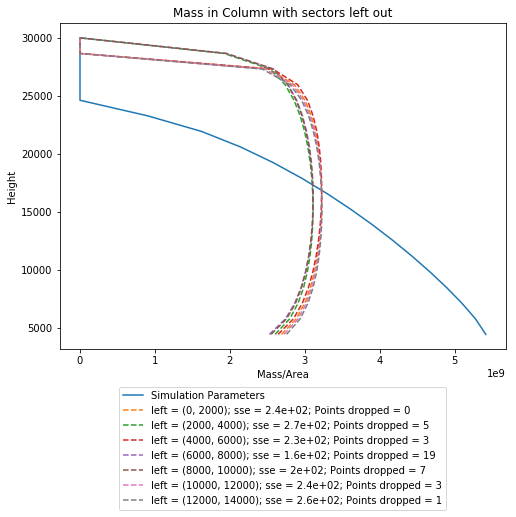

In [17]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                            config["VENT_ELEVATION"], 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"],
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

table = pd.DataFrame(columns=[
    "Sector Removed", 
    "Points dropped", 
    "a", 
    "b", 
    "Column Height", 
    "Goodness of Fit"
])

for i, sec, mass, sse, numpts in zip(list(range(len(sectors))), sectors, inverted_masses_list, sse_list, numpoints_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="left = (%d, %d); sse = %.2g; Points dropped = %s"%(
             sec[0],
             sec[1],
             sse, 
             numpts
         ))
    table = table.append({
        "Sector Removed": "(%d, %d)"%(sec[0], sec[1]),
        "Points dropped": numpts,
        "a": params_list[i]["a"],
        "b": params_list[i]["b"],
        "Column Height": params_list[i]["h1"],
        "Goodness of Fit": sse,
    }, ignore_index=True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column with sectors left out")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
# plt.show()

plt.savefig("data/colima/SEC_CV_%s_%s.png"%(file_tag, err_type), dpi=300, bbox_inches='tight')
display(table)
print(table.to_latex(index=False, float_format="%.2f"))
file = open("data/colima/SEC_CV_%s_%s.tex"%(file_tag, err_type), "w")
file.write(table.to_latex(index=False, float_format="%.2f"))
file.close()

## Left Out Phi Classes

========LEFT OUT: [-5,-4)========


38

a* = -2.21739	b* = -1.95838            	h1* = 3.20469
a = 1.10889	b = 1.14109	h1 = 28807.21631
Success: True, Optimization terminated successfully.
Iterations: 181
SSE: 227.04377532416237


Height  Suspended Mass
0    4430.75    2.669397e+09
1    5776.50    2.855706e+09
2    7122.25    2.959370e+09
3    8468.00    3.026067e+09
4    9813.75    3.070696e+09
5   11159.50    3.099961e+09
6   12505.25    3.117353e+09
7   13851.00    3.124796e+09
8   15196.75    3.123306e+09
9   16542.50    3.113277e+09
10  17888.25    3.094594e+09
11  19234.00    3.066615e+09
12  20579.75    3.028044e+09
13  21925.50    2.976617e+09
14  23271.25    2.908390e+09
15  24617.00    2.816043e+09
16  25962.75    2.683926e+09
17  27308.50    2.467243e+09
18  28654.25    1.798601e+09
19  30000.00    0.000000e+00

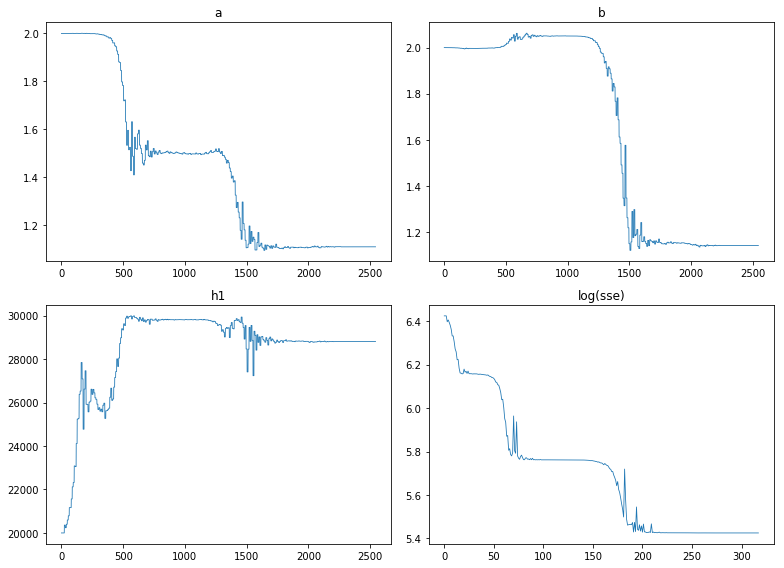

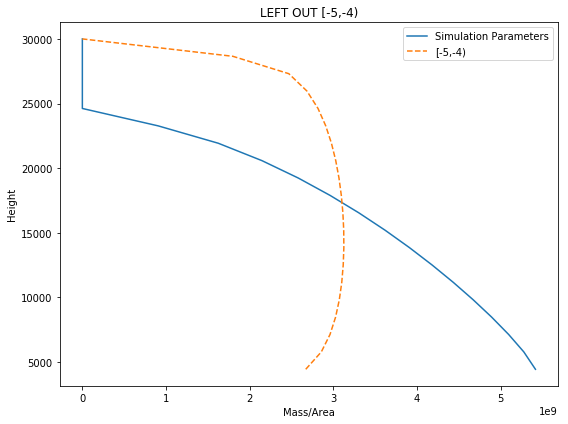

========LEFT OUT: [-4,-3)========


38

a* = -2.34263	b* = -1.75622            	h1* = 3.21512
a = 1.09607	b = 1.17270	h1 = 28819.34246
Success: True, Optimization terminated successfully.
Iterations: 163
SSE: 199.30122382859048


Height  Suspended Mass
0    4430.75    2.821556e+09
1    5776.50    2.986433e+09
2    7122.25    3.072963e+09
3    8468.00    3.124340e+09
4    9813.75    3.154552e+09
5   11159.50    3.169837e+09
6   12505.25    3.173394e+09
7   13851.00    3.166930e+09
8   15196.75    3.151282e+09
9   16542.50    3.126671e+09
10  17888.25    3.092794e+09
11  19234.00    3.048794e+09
12  20579.75    2.993101e+09
13  21925.50    2.923070e+09
14  23271.25    2.834194e+09
15  24617.00    2.718230e+09
16  25962.75    2.557787e+09
17  27308.50    2.303968e+09
18  28654.25    1.580105e+09
19  30000.00    0.000000e+00

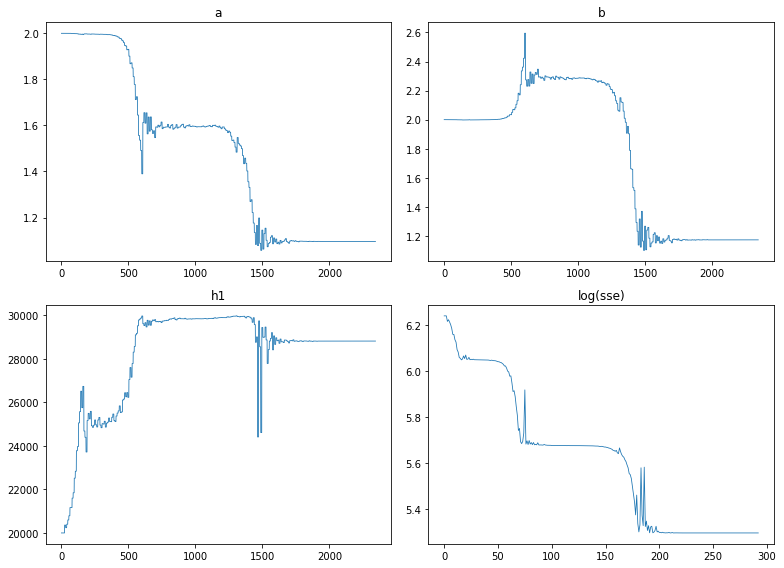

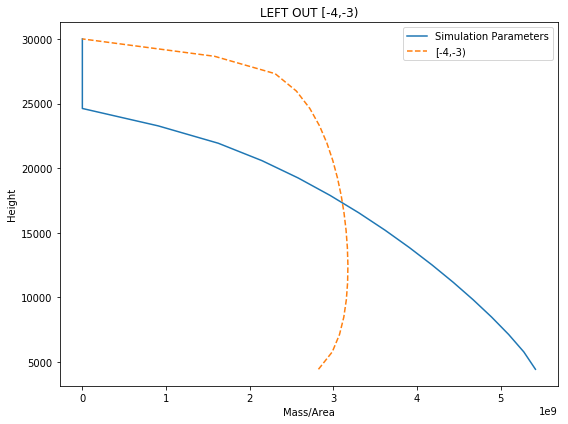

========LEFT OUT: [-3,-2)========


38

a* = -2.36942	b* = -1.78336            	h1* = 3.21439
a = 1.09354	b = 1.16807	h1 = 28818.49975
Success: True, Optimization terminated successfully.
Iterations: 159
SSE: 205.9545014637329


Height  Suspended Mass
0    4430.75    2.824140e+09
1    5776.50    2.984694e+09
2    7122.25    3.068866e+09
3    8468.00    3.118818e+09
4    9813.75    3.148188e+09
5   11159.50    3.163050e+09
6   12505.25    3.166517e+09
7   13851.00    3.160252e+09
8   15196.75    3.145063e+09
9   16542.50    3.121163e+09
10  17888.25    3.088252e+09
11  19234.00    3.045489e+09
12  20579.75    2.991333e+09
13  21925.50    2.923193e+09
14  23271.25    2.836649e+09
15  24617.00    2.723613e+09
16  25962.75    2.566995e+09
17  27308.50    2.318644e+09
18  28654.25    1.605082e+09
19  30000.00    0.000000e+00

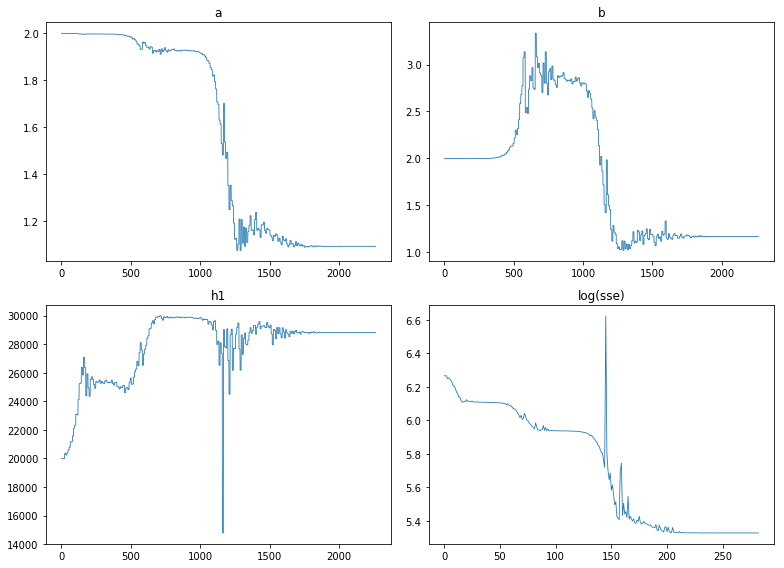

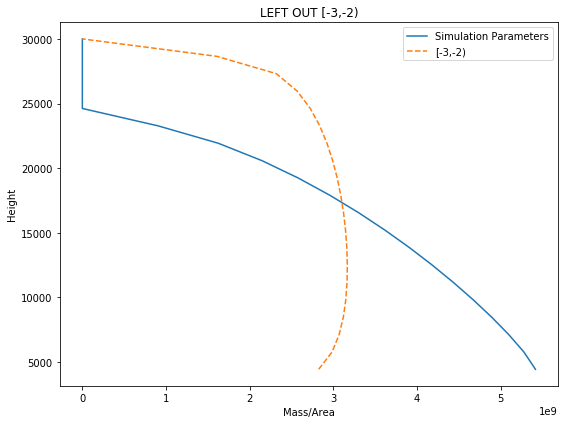

========LEFT OUT: [-2,-1)========


38

a* = -2.24811	b* = -2.35681            	h1* = 2.53016
a = 1.10560	b = 1.09472	h1 = 27703.29272
Success: True, Optimization terminated successfully.
Iterations: 190
SSE: 187.25312332350256


Height  Suspended Mass
0    4430.75    2.708463e+09
1    5776.50    2.897750e+09
2    7122.25    3.006425e+09
3    8468.00    3.079370e+09
4    9813.75    3.131207e+09
5   11159.50    3.168517e+09
6   12505.25    3.194739e+09
7   13851.00    3.211775e+09
8   15196.75    3.220643e+09
9   16542.50    3.221746e+09
10  17888.25    3.214968e+09
11  19234.00    3.199636e+09
12  20579.75    3.174337e+09
13  21925.50    3.136449e+09
14  23271.25    3.081019e+09
15  24617.00    2.997555e+09
16  25962.75    2.857494e+09
17  27308.50    2.497906e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

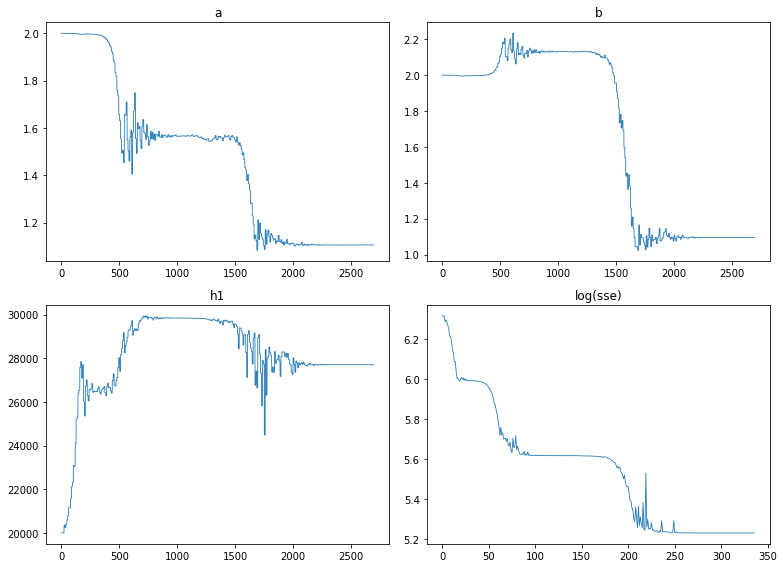

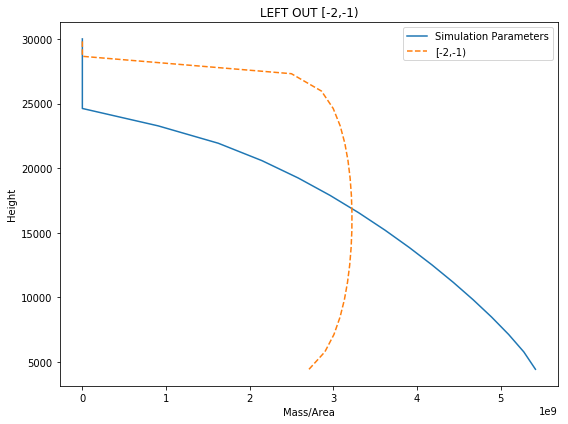

========LEFT OUT: [-1,0)========


38

a* = -2.24530	b* = -1.86529            	h1* = 3.20490
a = 1.10590	b = 1.15485	h1 = 28807.46029
Success: True, Optimization terminated successfully.
Iterations: 176
SSE: 207.12427062011756


Height  Suspended Mass
0    4430.75    2.721363e+09
1    5776.50    2.902987e+09
2    7122.25    3.002226e+09
3    8468.00    3.064540e+09
4    9813.75    3.104731e+09
5   11159.50    3.129441e+09
6   12505.25    3.142114e+09
7   13851.00    3.144625e+09
8   15196.75    3.137941e+09
9   16542.50    3.122402e+09
10  17888.25    3.097819e+09
11  19234.00    3.063460e+09
12  20579.75    3.017906e+09
13  21925.50    2.958711e+09
14  23271.25    2.881657e+09
15  24617.00    2.778952e+09
16  25962.75    2.634022e+09
17  27308.50    2.399723e+09
18  28654.25    1.695381e+09
19  30000.00    0.000000e+00

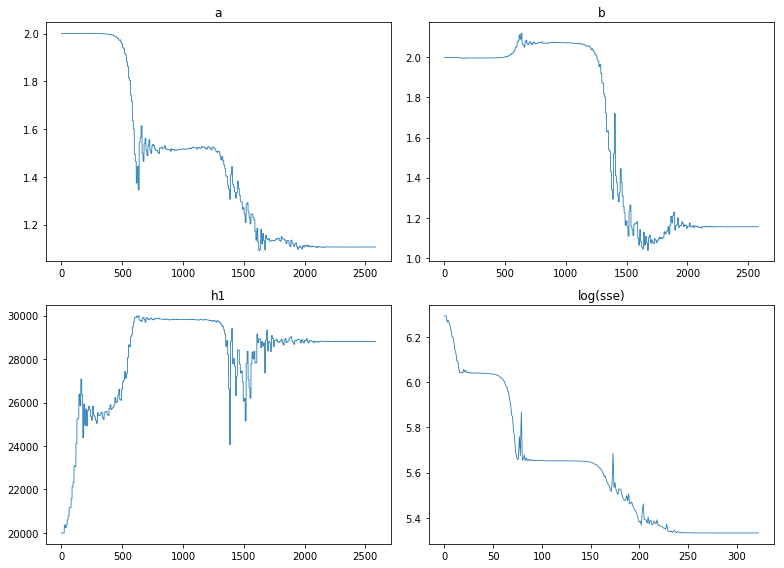

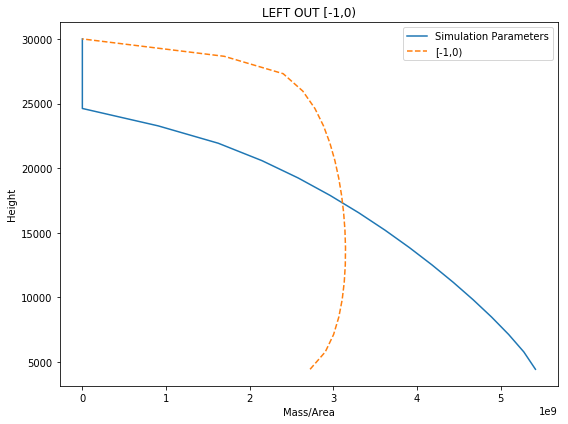

========LEFT OUT: [0,1)========


38

a* = -2.14217	b* = -2.08168            	h1* = 3.20210
a = 1.11740	b = 1.12472	h1 = 28804.18523
Success: True, Optimization terminated successfully.
Iterations: 195
SSE: 219.5824490119001


Height  Suspended Mass
0    4430.75    2.581821e+09
1    5776.50    2.780933e+09
2    7122.25    2.894689e+09
3    8468.00    2.970290e+09
4    9813.75    3.023205e+09
5   11159.50    3.060428e+09
6   12505.25    3.085635e+09
7   13851.00    3.100881e+09
8   15196.75    3.107292e+09
9   16542.50    3.105370e+09
10  17888.25    3.095108e+09
11  19234.00    3.075995e+09
12  20579.75    3.046901e+09
13  21925.50    3.005788e+09
14  23271.25    2.949061e+09
15  24617.00    2.869981e+09
16  25962.75    2.754032e+09
17  27308.50    2.559317e+09
18  28654.25    1.933271e+09
19  30000.00    0.000000e+00

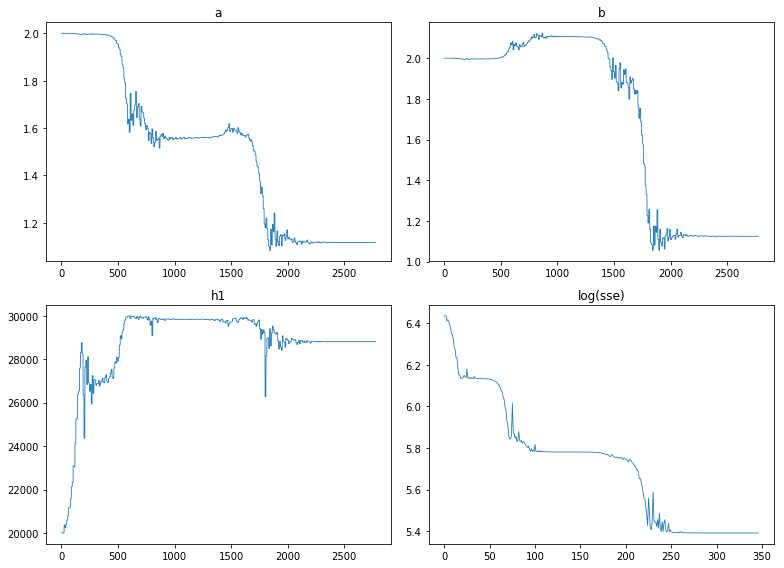

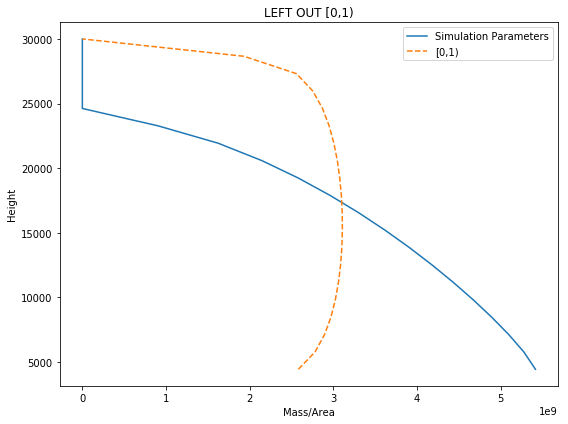

========LEFT OUT: [1,2)========


38

a* = -2.07237	b* = -2.12326            	h1* = 3.20316
a = 1.12589	b = 1.11964	h1 = 28805.42314
Success: True, Optimization terminated successfully.
Iterations: 171
SSE: 213.15816778430036


Height  Suspended Mass
0    4430.75    2.523975e+09
1    5776.50    2.735457e+09
2    7122.25    2.858043e+09
3    8468.00    2.940815e+09
4    9813.75    2.999924e+09
5   11159.50    3.042701e+09
6   12505.25    3.073018e+09
7   13851.00    3.093060e+09
8   15196.75    3.104045e+09
9   16542.50    3.106547e+09
10  17888.25    3.100622e+09
11  19234.00    3.085818e+09
12  20579.75    3.061072e+09
13  21925.50    3.024422e+09
14  23271.25    2.972383e+09
15  24617.00    2.898387e+09
16  25962.75    2.788255e+09
17  27308.50    2.600963e+09
18  28654.25    1.990494e+09
19  30000.00    0.000000e+00

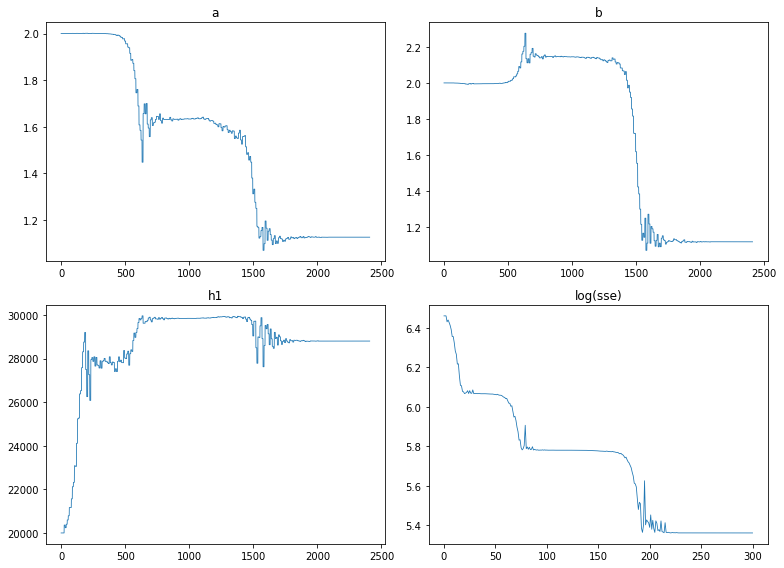

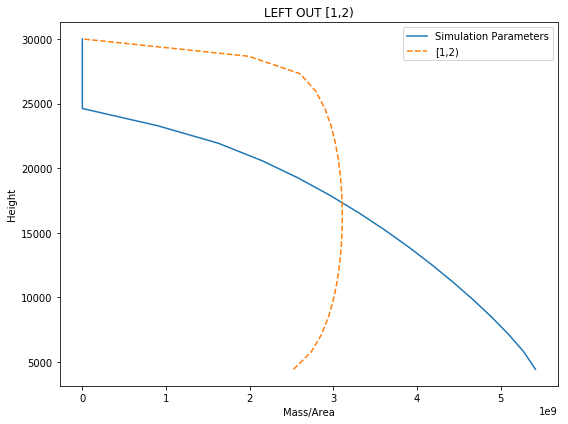

========LEFT OUT: [2,3)========


38

a* = -2.11002	b* = -2.05861            	h1* = 3.20607
a = 1.12124	b = 1.12763	h1 = 28808.83084
Success: True, Optimization terminated successfully.
Iterations: 205
SSE: 219.35441904863055


Height  Suspended Mass
0    4430.75    2.568319e+09
1    5776.50    2.773300e+09
2    7122.25    2.890734e+09
3    8468.00    2.968959e+09
4    9813.75    3.023841e+09
5   11159.50    3.062566e+09
6   12505.25    3.088912e+09
7   13851.00    3.104995e+09
8   15196.75    3.111979e+09
9   16542.50    3.110383e+09
10  17888.25    3.100207e+09
11  19234.00    3.080934e+09
12  20579.75    3.051415e+09
13  21925.50    3.009574e+09
14  23271.25    2.951748e+09
15  24617.00    2.871075e+09
16  25962.75    2.752799e+09
17  27308.50    2.554435e+09
18  28654.25    1.923824e+09
19  30000.00    0.000000e+00

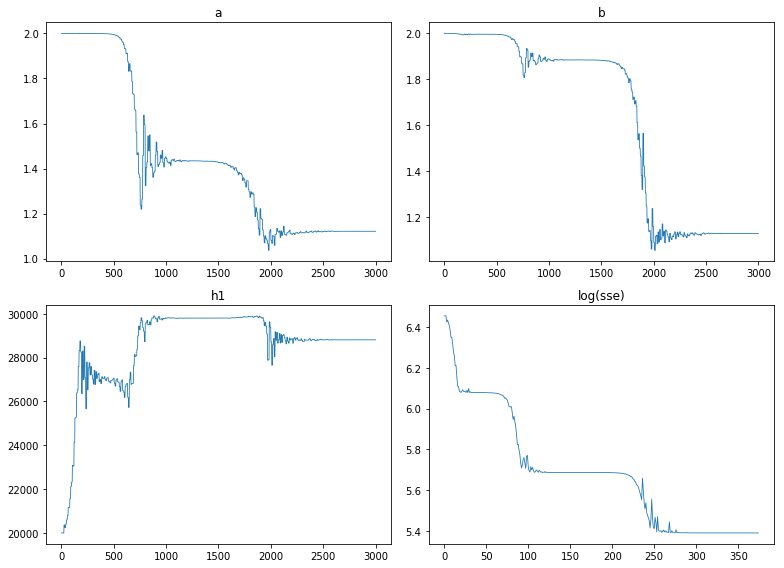

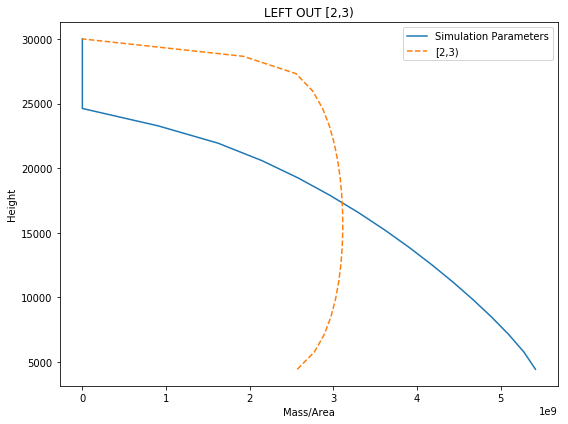

========LEFT OUT: [3,4)========


38

a* = -2.04369	b* = -2.15748            	h1* = 3.20886
a = 1.12955	b = 1.11562	h1 = 28812.08523
Success: True, Optimization terminated successfully.
Iterations: 197
SSE: 190.31868588487225


Height  Suspended Mass
0    4430.75    2.494157e+09
1    5776.50    2.710636e+09
2    7122.25    2.837013e+09
3    8468.00    2.923014e+09
4    9813.75    2.985033e+09
5   11159.50    3.030527e+09
6   12505.25    3.063440e+09
7   13851.00    3.086011e+09
8   15196.75    3.099499e+09
9   16542.50    3.104515e+09
10  17888.25    3.101150e+09
11  19234.00    3.088994e+09
12  20579.75    3.067030e+09
13  21925.50    3.033368e+09
14  23271.25    2.984622e+09
15  24617.00    2.914407e+09
16  25962.75    2.808910e+09
17  27308.50    2.628192e+09
18  28654.25    2.039482e+09
19  30000.00    0.000000e+00

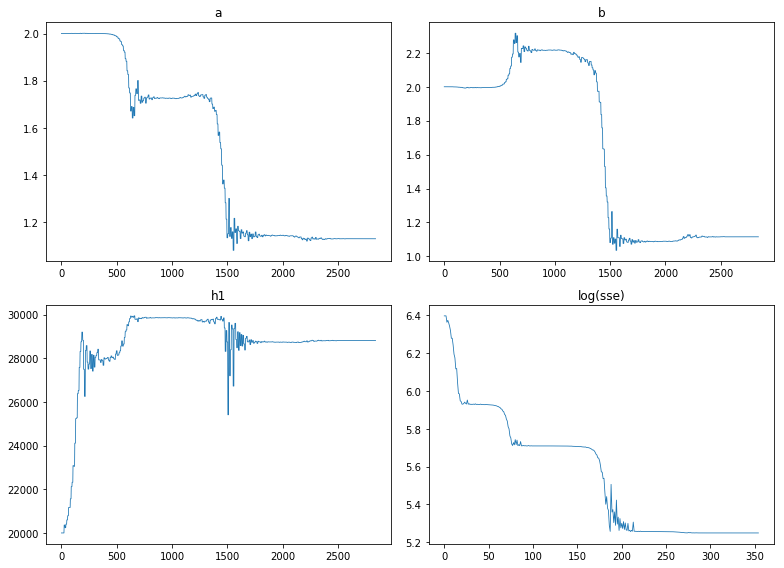

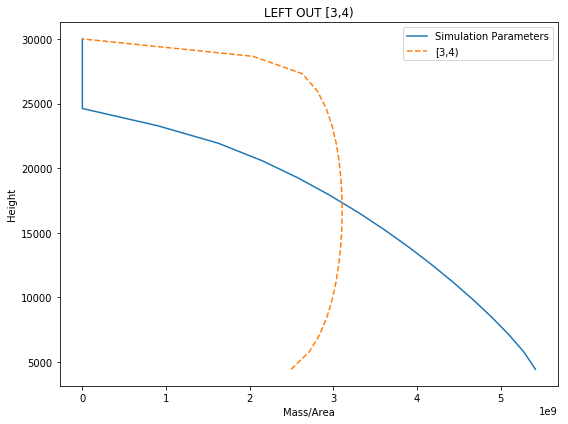

In [18]:
priors_vals = {
    "a": 2,
    "b": 2,
    "h1": 20000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h1" : True
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)



inverted_masses_list = []
params_list = []
sse_list = []
for i, phi_step in enumerate(phi_steps):
    loo_df = df.copy()
    loo_df = loo_df.drop(phi_step["interval"], 1)
    
    print("========LEFT OUT: %s========"%(phi_step["interval"]))
    classes = phi_steps.copy()
    del classes[i]
    display(len(loo_df))
    out = gaussian_stack_inversion(
        loo_df, len(loo_df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        classes, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_dist = beta(config["ALPHA"],config["BETA"])

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("LEFT OUT %s"%(phi_step["interval"]))
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

Grain Size Removed         a         b  Column Height  Goodness of Fit
0           (-5, -4)  1.108893  1.141086   28807.216311       227.043775
1           (-4, -3)  1.096074  1.172696   28819.342462       199.301224
2           (-3, -2)  1.093535  1.168073   28818.499752       205.954501
3           (-2, -1)  1.105599  1.094721   27703.292719       187.253123
4            (-1, 0)  1.105896  1.154851   28807.460286       207.124271
5             (0, 1)  1.117400  1.124720   28804.185227       219.582449
6             (1, 2)  1.125887  1.119641   28805.423140       213.158168
7             (2, 3)  1.121235  1.127631   28808.830839       219.354419
8             (3, 4)  1.129550  1.115616   28812.085233       190.318686

\begin{tabular}{lrrrr}
\toprule
Grain Size Removed &    a &    b &  Column Height &  Goodness of Fit \\
\midrule
          (-5, -4) & 1.11 & 1.14 &       28807.22 &           227.04 \\
          (-4, -3) & 1.10 & 1.17 &       28819.34 &           199.30 \\
          (-3, -2) & 1.09 & 1.17 &       28818.50 &           205.95 \\
          (-2, -1) & 1.11 & 1.09 &       27703.29 &           187.25 \\
           (-1, 0) & 1.11 & 1.15 &       28807.46 &           207.12 \\
            (0, 1) & 1.12 & 1.12 &       28804.19 &           219.58 \\
            (1, 2) & 1.13 & 1.12 &       28805.42 &           213.16 \\
            (2, 3) & 1.12 & 1.13 &       28808.83 &           219.35 \\
            (3, 4) & 1.13 & 1.12 &       28812.09 &           190.32 \\
\bottomrule
\end{tabular}



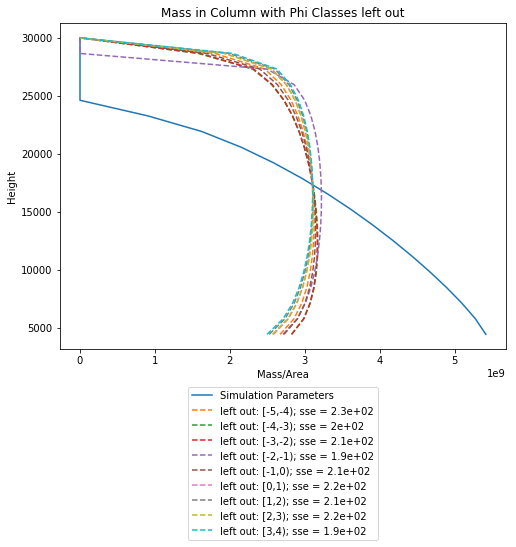

In [19]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

table = pd.DataFrame(columns=[
    "Grain Size Removed", 
    "a", 
    "b", 
    "Column Height", 
    "Goodness of Fit"
])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for i, phi_step, mass, sse in zip(list(range(len(phi_steps))), phi_steps, inverted_masses_list, sse_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="left out: %s; sse = %.2g"%(phi_step["interval"], sse))
    table = table.append({
        "Grain Size Removed": "(%.2g, %.2g)"%(phi_step["lower"], phi_step["upper"]),
        "a": params_list[i]["a"],
        "b": params_list[i]["b"],
        "Column Height": params_list[i]["h1"],
        "Goodness of Fit": sse,
    }, ignore_index=True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column with Phi Classes left out")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
# plt.show()
plt.savefig("data/colima/GS_CV_%s_%s.png"%(file_tag, err_type), dpi=300, bbox_inches='tight')
display(table)
print(table.to_latex(index=False, float_format="%.2f"))
file = open("data/colima/GS_CV_%s_%s.tex"%(file_tag, err_type), "w")
file.write(table.to_latex(index=False, float_format="%.2f"))
file.close()

In [20]:
n = 5
p = 6
q = 4

A = np.random.rand(n, p, q)
Q = np.random.rand(q, p, 1)
print(A.shape)
print(Q.shape)

print(A)

print(Q)

# M = np.tensordot(A, Q, (2, 1))
M2 = np.einsum('ijk,kj', A, Q)

print(M.shape)

(5, 6, 4)
(4, 6, 1)
[[[0.63602936 0.54460049 0.9230884  0.24665137]
  [0.37598527 0.54799389 0.84870556 0.00279927]
  [0.63732628 0.45314455 0.61432206 0.76864846]
  [0.21564551 0.83845485 0.63727816 0.97348578]
  [0.09748003 0.85225369 0.21830903 0.36356665]
  [0.27881607 0.05601951 0.08003789 0.83662655]]

 [[0.58910208 0.27645428 0.84832393 0.68302461]
  [0.22720965 0.30657702 0.88804987 0.04968438]
  [0.69884954 0.52296194 0.3374537  0.55510722]
  [0.80757779 0.60023576 0.78602944 0.57863345]
  [0.37797633 0.61125274 0.98138747 0.51099483]
  [0.61878763 0.22287785 0.70243489 0.81868919]]

 [[0.43152989 0.36824744 0.36325477 0.34464354]
  [0.72894595 0.511397   0.75129197 0.25731566]
  [0.3095203  0.34010604 0.1777883  0.44691104]
  [0.31850313 0.62523947 0.79999219 0.76558621]
  [0.44390699 0.88688047 0.21202901 0.38618389]
  [0.81140239 0.97603041 0.47894836 0.29876805]]

 [[0.39545794 0.2213227  0.21547957 0.65059828]
  [0.92512966 0.86907433 0.9864646  0.31151234]
  [0.14657447 

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.